In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import special


import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:


#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only'


#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-0.5k-perfect'

#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-0.5k-mediumbad'





#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-5k-perfect'

#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-50k-goodres'

input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-5k-nominal-resolution'

#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-5k-mediumbad'






#fitType = 'bin center approximation'
fitType = 'integral within bin'



#-- the magic number.  Ok for goodres 50k
rcond_val = 0.001


#-- improves for mediumbad 5k and perfect 5k, NFG for nominal, bit biased for goodres,
#rcond_val = 0.0002



#-- biased for goodres 50k
#rcond_val = 0.00032

#-- very biased for goodres 50k
#rcond_val = 0.0015

#-- very biased for goodres 50k
#rcond_val = 0.00005


In [3]:
with open( '%s/bootstrap-output-histograms.npy' % input_dir, 'rb') as f :
    boot_hist_content = np.load(f, allow_pickle=True )
    hist_bin_edges = np.load(f, allow_pickle=True)

In [4]:
hist_nbins = len(hist_bin_edges) - 1
hist_xlow = hist_bin_edges[0]
hist_xhigh = hist_bin_edges[-1]
print('\n\n  hist_nbins = %d,  range %.2f to %.2f\n\n' % (hist_nbins, hist_xlow, hist_xhigh))



  hist_nbins = 20,  range -3.00 to 3.00




In [5]:
hist_bin_edges

array([-3. , -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ,
        0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ])

In [6]:
hist_bin_centers = np.zeros( hist_nbins )
for bi in range(hist_nbins) :
    hist_bin_centers[bi] = 0.5*(hist_bin_edges[bi] + hist_bin_edges[bi+1])

In [7]:
hist_bin_centers

array([-2.85, -2.55, -2.25, -1.95, -1.65, -1.35, -1.05, -0.75, -0.45,
       -0.15,  0.15,  0.45,  0.75,  1.05,  1.35,  1.65,  1.95,  2.25,
        2.55,  2.85])

In [8]:
bin_width = hist_bin_edges[1] - hist_bin_edges[0]

In [9]:
boot_hist_content.shape

(5000, 20)

In [10]:
n_samples = len(boot_hist_content)
print('\n\n Have %d samples\n\n' % n_samples)



 Have 5000 samples




In [11]:
boot_hist_content

array([[  4.412735  ,  12.11544754,  34.27210016, ..., 103.26210978,
         45.03312245,  19.8948256 ],
       [  2.88433215,   9.60822099,  32.99865762, ..., 118.48466423,
         53.66921985,  20.35647372],
       [  4.89960014,  15.04072333,  42.03704384, ..., 112.82250967,
         49.89414847,  19.92362046],
       ...,
       [  6.18508983,  14.58111802,  36.39456558, ..., 100.96057399,
         42.6976351 ,  17.26151954],
       [  6.18213016,  16.4882954 ,  40.46000657, ..., 103.16637107,
         45.89117566,  19.50658297],
       [  4.29652073,  13.00920992,  38.35371158, ..., 113.12191705,
         44.4370844 ,  13.6433459 ]])

In [12]:
boot_hist_content[:,6]

array([524.42269806, 501.99950615, 514.19167861, ..., 504.17491546,
       477.42864162, 489.84055656])

In [13]:
hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

for bi in range(hist_nbins) :
    
    for bj in range( hist_nbins ) :
        
        ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        
        hist_corr_mat[bi,bj] = ccm[0,1]
        
        hist_cov_mat[bi,bj] = cvm[0,1]
        

In [14]:
hist_corr_mat[0,hist_nbins-1] = -1.

<function matplotlib.pyplot.show(close=None, block=None)>

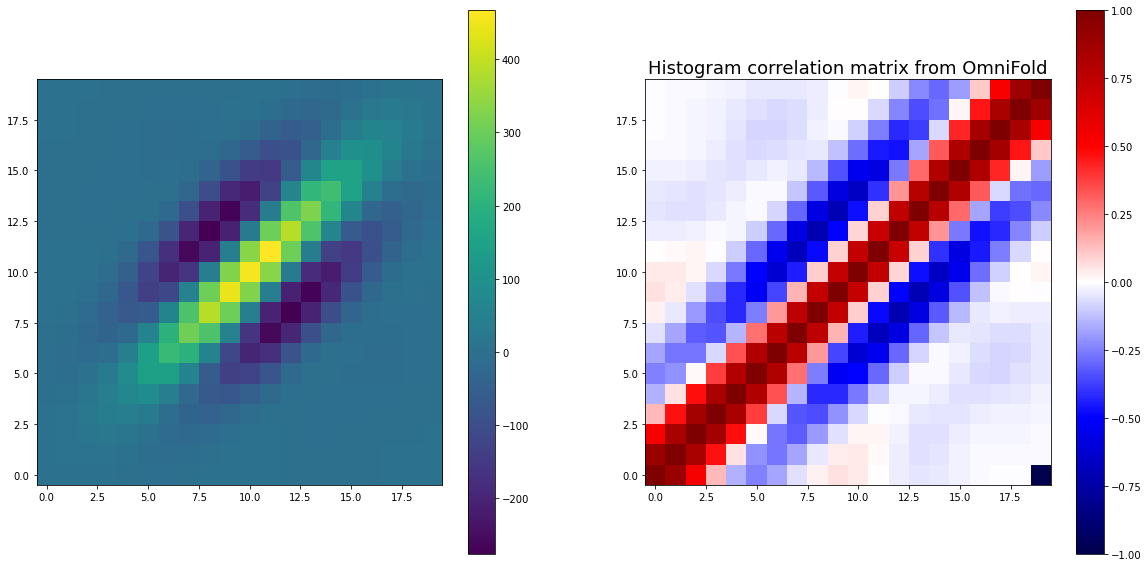

In [15]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [16]:
min_cov_element = np.min(hist_cov_mat)
max_cov_element = np.max(hist_cov_mat)
print('\n\n Min and max elements of cov mat:  %.2f , %.2f\n\n' % (min_cov_element, max_cov_element))
hist_cov_mat_copy = np.copy( hist_cov_mat )
hist_cov_mat_copy[0,hist_nbins-1] = -1. * max_cov_element



 Min and max elements of cov mat:  -275.87 , 467.06




<function matplotlib.pyplot.show(close=None, block=None)>

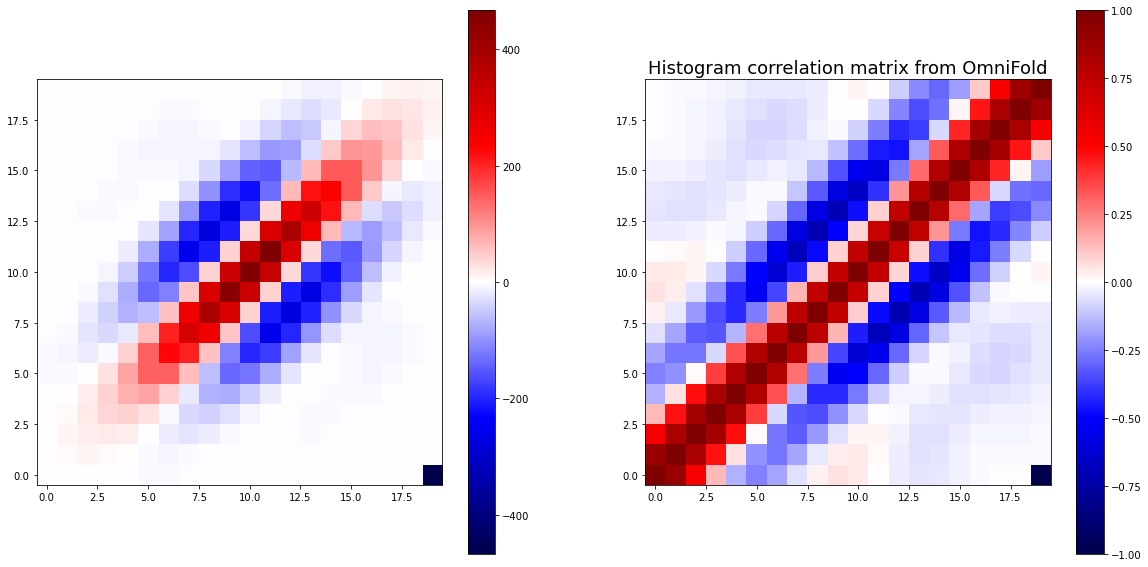

In [17]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [18]:
for bi in range(hist_nbins) :
    for bj in range(hist_nbins ) :
        
        calc_corr = hist_cov_mat[bi,bj] / np.sqrt( hist_cov_mat[bi,bi] * hist_cov_mat[bj,bj])
        
        print('  %2d, %2d :  histi  %10.2f   histj %10.2f  cov = %9.3f   cor = %9.4f  (%9.4f)' % 
              (bi, bj, boot_hist_content[0,bi], boot_hist_content[0,bj],
               hist_cov_mat[bi,bj], hist_corr_mat[bi,bj], calc_corr))



   0,  0 :  histi        4.41   histj       4.41  cov =     2.086   cor =    1.0000  (   1.0000)
   0,  1 :  histi        4.41   histj      12.12  cov =     3.078   cor =    0.8944  (   0.8944)
   0,  2 :  histi        4.41   histj      34.27  cov =     3.093   cor =    0.5280  (   0.5280)
   0,  3 :  histi        4.41   histj      77.23  cov =     1.216   cor =    0.1383  (   0.1383)
   0,  4 :  histi        4.41   histj     160.45  cov =    -1.814   cor =   -0.1494  (  -0.1494)
   0,  5 :  histi        4.41   histj     318.97  cov =    -4.251   cor =   -0.2437  (  -0.2437)
   0,  6 :  histi        4.41   histj     524.42  cov =    -3.856   cor =   -0.1771  (  -0.1771)
   0,  7 :  histi        4.41   histj     781.84  cov =    -1.564   cor =   -0.0619  (  -0.0619)
   0,  8 :  histi        4.41   histj    1045.92  cov =     0.734   cor =    0.0258  (   0.0258)
   0,  9 :  histi        4.41   histj    1242.13  cov =     1.708   cor =    0.0560  (   0.0560)
   0, 10 :  histi        4.41 

In [19]:
print('      ', end='')
for bj in range( hist_nbins ) :
    print('   %2d   ' % bj, end='')
print()

for bi in range( hist_nbins ) :
    print(' %2d : ' % bi, end='')
    for bj in range( hist_nbins ) :
        print( ' %6.3f ' % hist_corr_mat[bi,bj], end='')
    print()

          0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19   
  0 :   1.000   0.894   0.528   0.138  -0.149  -0.244  -0.177  -0.062   0.026   0.056   0.042   0.005  -0.034  -0.051  -0.044  -0.027  -0.012  -0.006  -0.005  -1.000 
  1 :   0.894   1.000   0.830   0.466   0.059  -0.214  -0.268  -0.173  -0.043   0.036   0.047   0.010  -0.039  -0.059  -0.049  -0.029  -0.013  -0.009  -0.010  -0.010 
  2 :   0.528   0.830   1.000   0.857   0.470   0.013  -0.271  -0.313  -0.196  -0.056   0.020   0.017  -0.029  -0.058  -0.055  -0.037  -0.021  -0.016  -0.016  -0.013 
  3 :   0.138   0.466   0.857   1.000   0.830   0.382  -0.073  -0.334  -0.349  -0.216  -0.072  -0.005  -0.014  -0.043  -0.054  -0.048  -0.036  -0.029  -0.024  -0.018 
  4 :  -0.149   0.059   0.470   0.830   1.000   0.803   0.342  -0.146  -0.421  -0.421  -0.260  -0.099  -0.022  -0.017  -0.038  -0.055  -0.058  -0.054  -0.042  -0.030

In [20]:
cov_det = np.linalg.det( hist_cov_mat )
print('\n\n Histogram covariance matrix determinant:  %9.4f\n\n' % cov_det)



 Histogram covariance matrix determinant:     4.9869




In [21]:
hist_cov_inv = np.linalg.inv( hist_cov_mat )
print(hist_cov_inv)

[[  92.81075403 -138.48258781  132.1245085  -108.04858553  106.32738998
   -93.2419948    97.56144324  -85.22882952   82.67361605  -66.68852038
    64.94585264  -48.04105903   47.51067356  -33.10987554   28.03991702
    -9.42721419    5.75799457    9.30812306   -9.18289841   18.63223506]
 [-138.48258781  238.39005296 -249.80879317  236.22629316 -234.74996077
   210.45177476 -203.07941677  179.13646683 -162.85735999  137.55806966
  -127.55001482  103.15824564  -96.92765981   78.44282282  -63.13516468
    36.04483485  -22.11964911    1.43394614    3.29694283  -13.84837857]
 [ 132.1245085  -249.80879317  300.14724259 -318.69694083  329.75859427
  -289.10212461  264.64390805 -222.57037475  195.60872007 -162.8608826
   151.24033741 -123.37223259  117.20920579  -95.73895731   77.42013405
   -44.52057839   27.33108637   -2.17932581   -3.67645489   16.53878642]
 [-108.04858553  236.22629316 -318.69694083  376.97531426 -402.45817497
   355.61939912 -314.11417304  261.72377244 -223.05068814  188

In [22]:
cov_inv_test = np.matmul( hist_cov_mat, hist_cov_inv )
print( cov_inv_test)

[[ 1.00000000e+00  6.95449848e-12 -1.18066144e-11  1.34993565e-11
  -7.00008356e-12  1.37449905e-11 -1.59139360e-11  9.14059844e-12
  -1.08607207e-11  1.75882505e-11 -1.37019032e-13  9.15957918e-12
  -6.77848668e-12  9.71303697e-12 -4.28132294e-12  3.22493822e-12
  -2.83986027e-12  1.03314713e-12 -9.15245422e-13  1.41424354e-13]
 [ 6.62993129e-13  1.00000000e+00 -6.77970623e-12  1.11349845e-12
  -8.26997074e-12  4.43994433e-12 -8.48133700e-12 -5.03205863e-13
  -2.35589709e-12  6.22413327e-12  1.65506376e-12  3.22514669e-12
  -1.92369688e-12  1.58368163e-12  3.82150043e-13  1.38793720e-12
  -7.25172384e-13 -1.00793979e-14 -6.92715971e-14 -1.98066544e-13]
 [ 1.06140586e-12 -5.19962986e-12  1.00000000e+00 -7.91173286e-12
  -7.12671718e-12 -1.48413609e-12 -3.49440020e-12 -3.86898236e-12
   8.79004453e-12 -7.41609479e-12  7.64757200e-13 -2.30379278e-13
  -1.93259385e-12 -3.84859297e-12  2.85522437e-12  2.08884959e-12
   1.11184803e-12 -5.55450532e-13  6.00239858e-13 -3.78121765e-13]
 [-1.01

<function matplotlib.pyplot.show(close=None, block=None)>

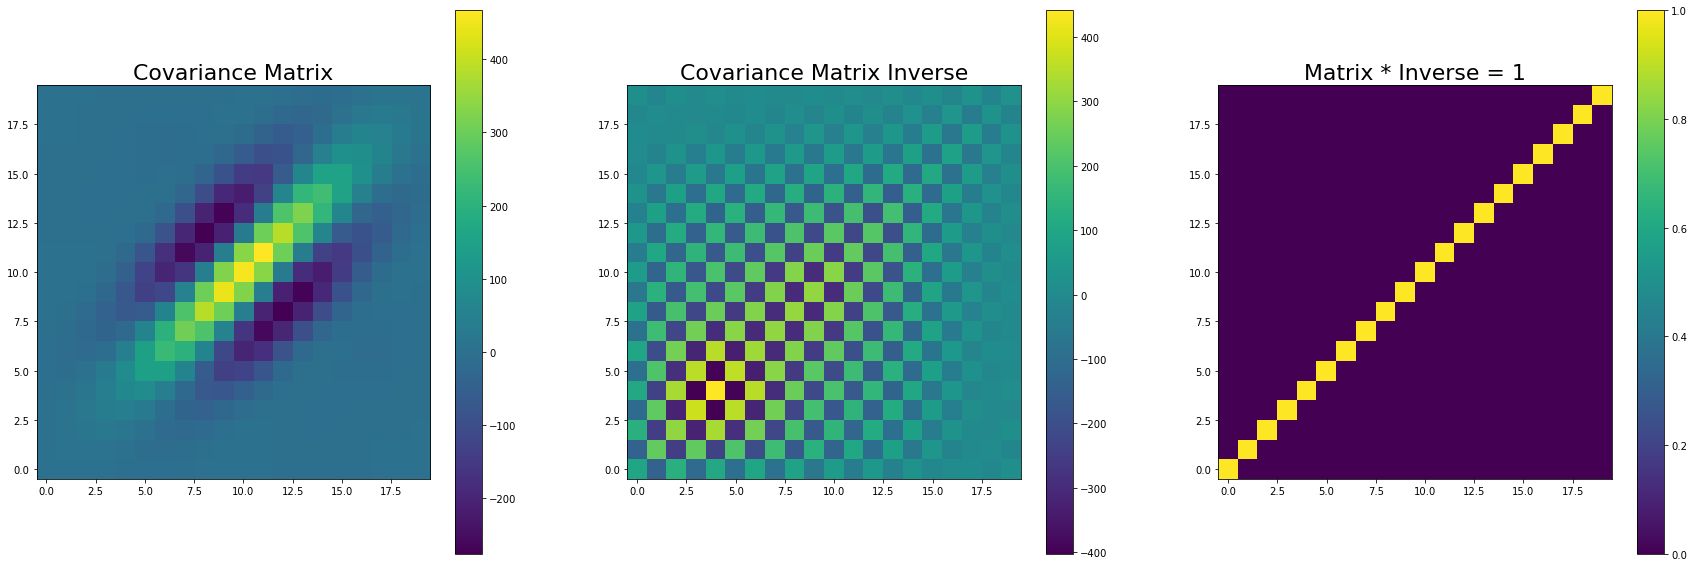

In [23]:
fig,ax = plt.subplots( 1, 3, figsize=(3*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im_covinv = ax[1].imshow(hist_cov_inv, origin='lower')
ax[1].figure.colorbar( im_covinv, ax=ax[1] )

im_covtest = ax[2].imshow(cov_inv_test, origin='lower')
ax[2].figure.colorbar( im_covtest, ax=ax[2] )

ax[0].set_title('Covariance Matrix', fontsize='22')
ax[1].set_title('Covariance Matrix Inverse', fontsize='22')
ax[2].set_title('Matrix * Inverse = 1', fontsize='22')

plt.show



In [24]:
ci_min = np.min(hist_cov_inv)
ci_max = np.max(hist_cov_inv)
print('\n\n min and max of covariance matrix inverse:  %.2f  %.2f\n\n' % (ci_min, ci_max))

hist_cov_inv_copy = np.copy( hist_cov_inv )
hist_cov_inv_copy[0,hist_nbins-1] = -1. * ci_max




 min and max of covariance matrix inverse:  -402.46  441.48




<function matplotlib.pyplot.show(close=None, block=None)>

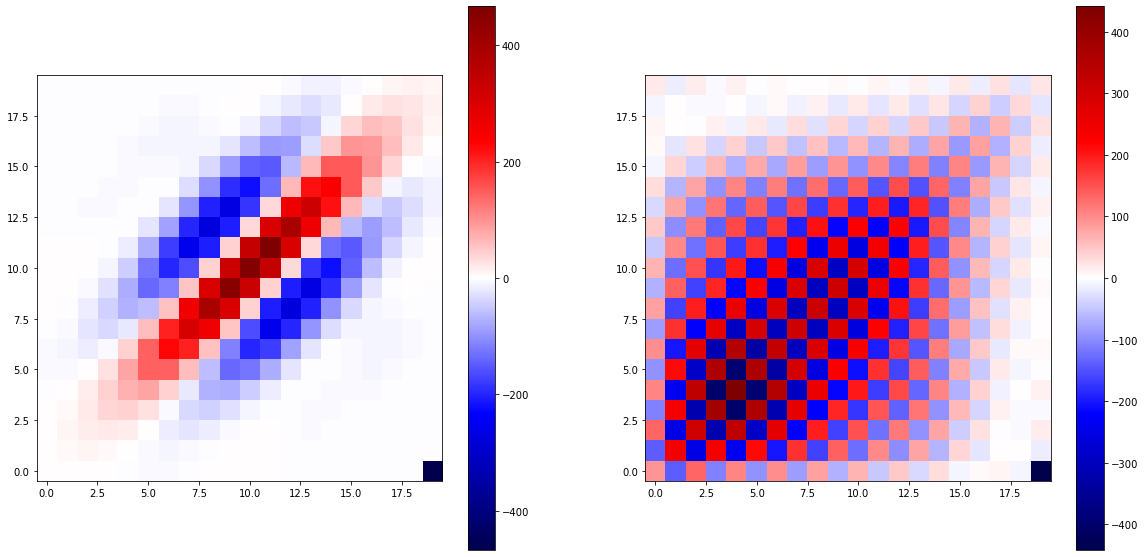

In [25]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

(-50.0, 50.0)

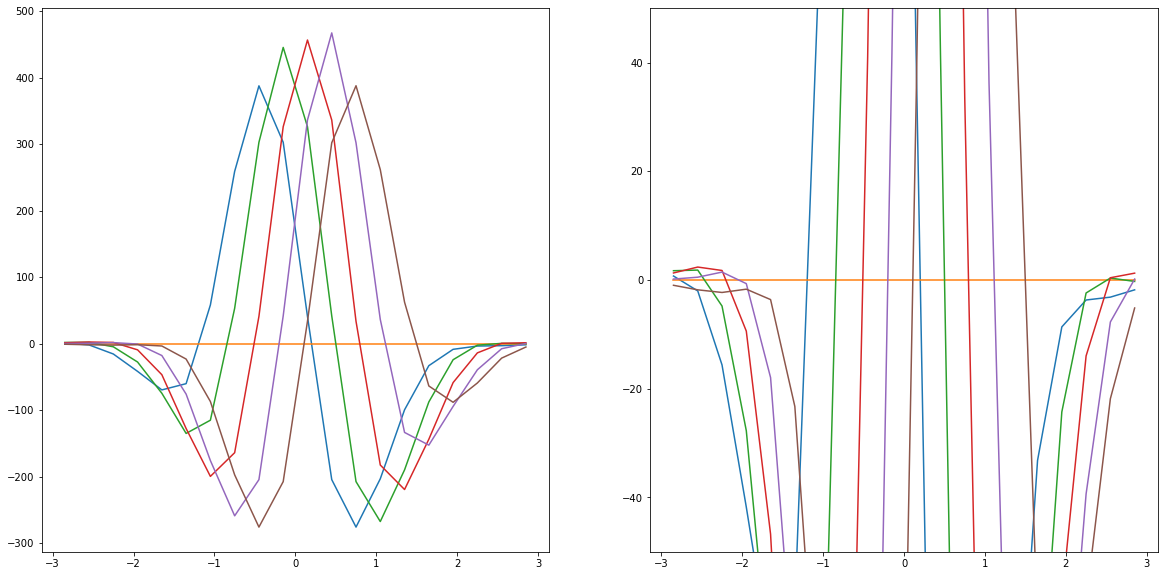

In [26]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[9,:] )
if hist_nbins >= 13 :
    ax[0].plot( hist_bin_centers, hist_cov_mat[10,:] )
    ax[0].plot( hist_bin_centers, hist_cov_mat[11,:] )
    ax[0].plot( hist_bin_centers, hist_cov_mat[12,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[9,:] )
if hist_nbins >= 13 :
    ax[1].plot( hist_bin_centers, hist_cov_mat[10,:] )
    ax[1].plot( hist_bin_centers, hist_cov_mat[11,:] )
    ax[1].plot( hist_bin_centers, hist_cov_mat[12,:] )


ax[1].set_ylim([-50,50])

(-50.0, 50.0)

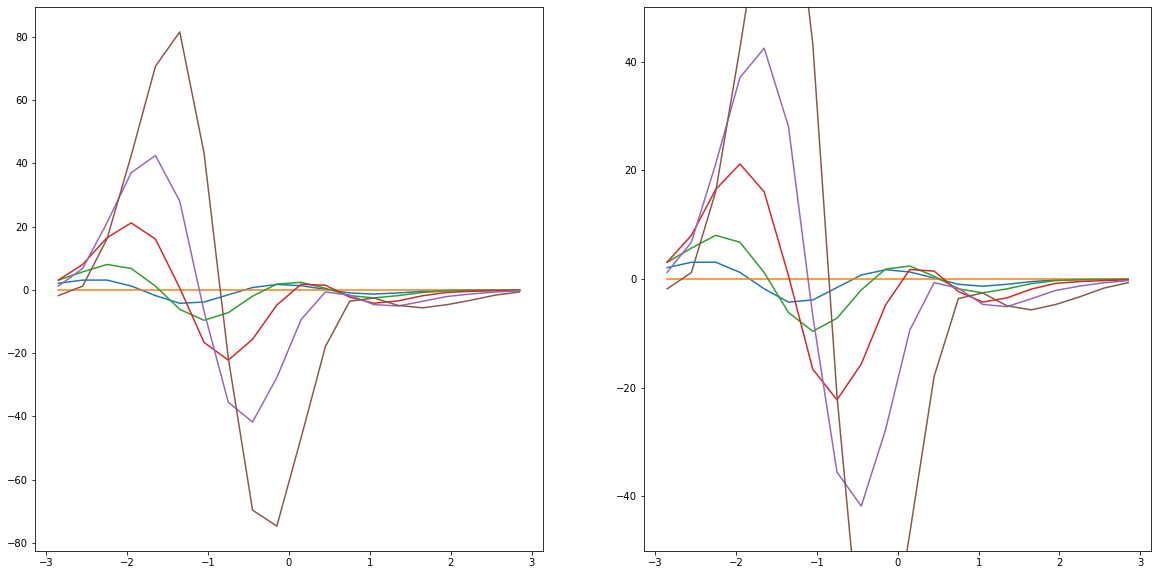

In [27]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[4,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[4,:] )


ax[1].set_ylim([-50,50])

## Try using the pseudo inverse of the covariance matrix for the chi2

In [28]:

#--- off
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat )


#--- not enough?
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.0001 )

#--- ok
##########hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.001 )
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.01 )

#-- probably too much
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.05 )


hist_cov_pinv = np.linalg.pinv( hist_cov_mat, rcond_val )



print(hist_cov_pinv)

[[ 8.14707514e-02  5.17881544e-02 -3.98356455e-02 -8.60699956e-02
  -1.33271637e-02  3.15484284e-02 -4.15556909e-02 -5.98641888e-02
   1.02551764e-02 -3.05355815e-03 -5.66476155e-02 -2.34852030e-02
   1.15354234e-02 -3.25736315e-02 -5.38623187e-02 -7.10071738e-04
   6.89392103e-03 -5.16214492e-02 -6.05249221e-02  9.94361155e-03]
 [ 5.17881544e-02  5.17796729e-02  9.73599594e-03 -3.69417872e-02
  -2.42637155e-02  1.73612703e-02  6.10218030e-03 -3.16181763e-02
  -8.80664293e-03  1.68545931e-02 -1.38746203e-02 -2.61731210e-02
   1.02581313e-02  5.43635929e-03 -2.82917240e-02 -1.17877897e-02
   1.25819545e-02 -2.43030831e-03 -2.66020275e-02 -2.21219131e-02]
 [-3.98356455e-02  9.73599594e-03  8.54467784e-02  7.70004499e-02
  -2.16820551e-02 -2.22738220e-02  7.84683988e-02  4.24839605e-02
  -3.23950380e-02  3.38349248e-02  6.74333650e-02 -7.61676604e-03
  -6.78717541e-04  6.19378117e-02  3.71492766e-02 -1.94557224e-02
   1.14092406e-02  7.91663263e-02  4.99019438e-02 -5.70185305e-02]
 [-8.60

In [29]:
hist_cov_pinv_minus_inv = hist_cov_pinv - hist_cov_inv

In [30]:
cov_pinv_test = np.matmul( hist_cov_mat, hist_cov_pinv )

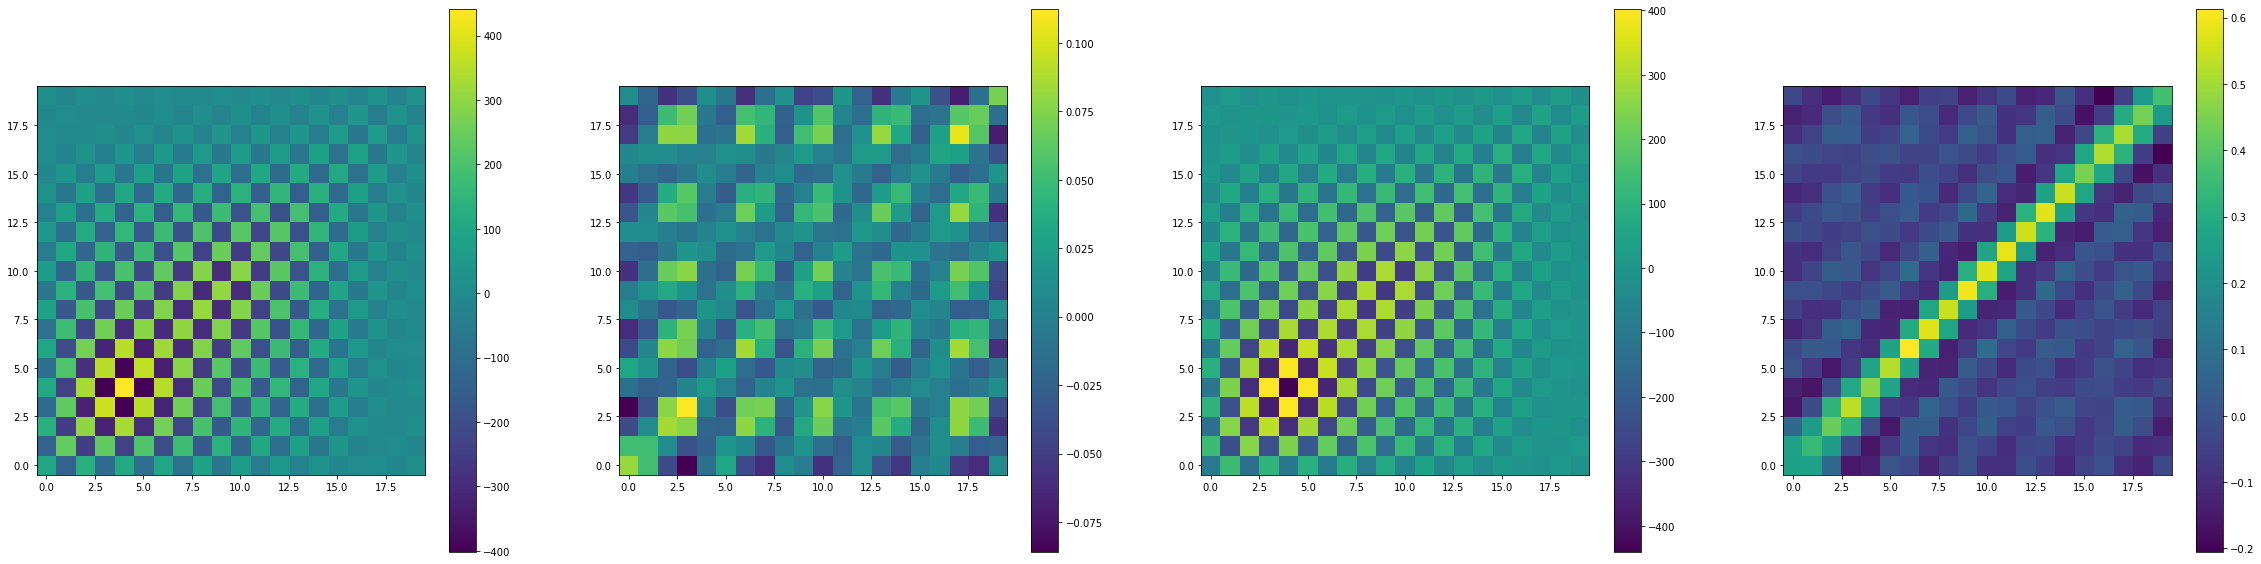

In [31]:
fig,ax = plt.subplots( 1, 4, figsize=(4*10,10))



im_covinv = ax[0].imshow(hist_cov_inv, origin='lower')
ax[0].figure.colorbar( im_covinv, ax=ax[0] )

im_covpinv = ax[1].imshow(hist_cov_pinv, origin='lower')
ax[1].figure.colorbar( im_covpinv, ax=ax[1] )

im_covpinvdiff = ax[2].imshow(hist_cov_pinv_minus_inv, origin='lower')
ax[2].figure.colorbar( im_covpinvdiff, ax=ax[2] )

im_pinv_test = ax[3].imshow(cov_pinv_test, origin='lower')
ax[3].figure.colorbar( im_pinv_test, ax=ax[3] )



In [32]:
cpi_min = np.min(hist_cov_pinv)
cpi_max = np.max(hist_cov_pinv)
print('\n\n min and max of covariance matrix pseudo inverse:  %.2f  %.2f\n\n' % (cpi_min, cpi_max))

hist_cov_pinv_copy = np.copy( hist_cov_pinv )
hist_cov_pinv_copy[0,hist_nbins-1] = -1. * cpi_max




 min and max of covariance matrix pseudo inverse:  -0.09  0.11




<function matplotlib.pyplot.show(close=None, block=None)>

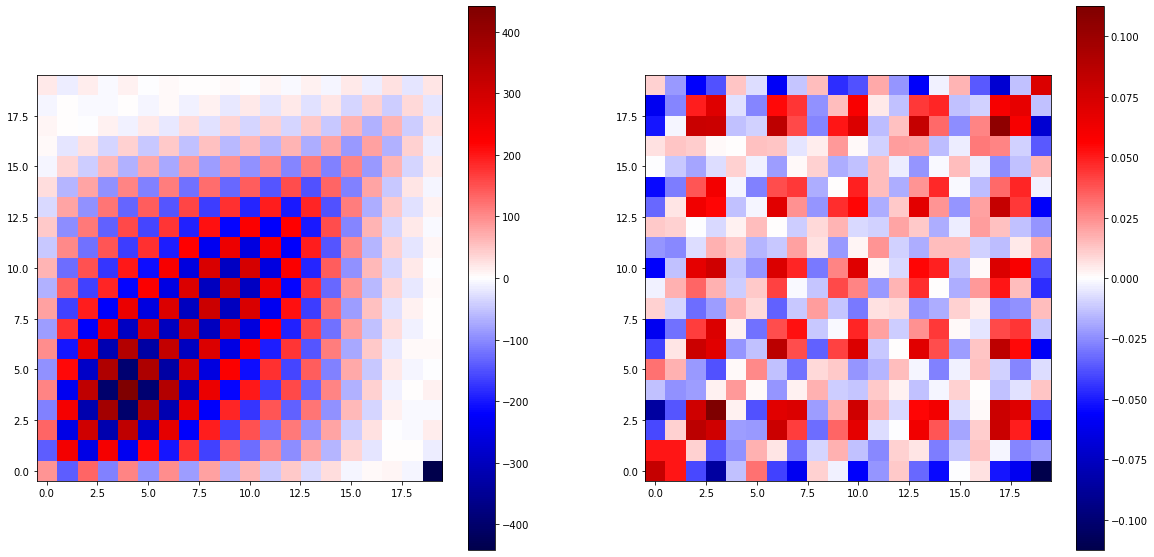

In [33]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_pinv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [34]:
hist_inverse_of_pinv = np.linalg.inv( hist_cov_pinv )

<function matplotlib.pyplot.show(close=None, block=None)>

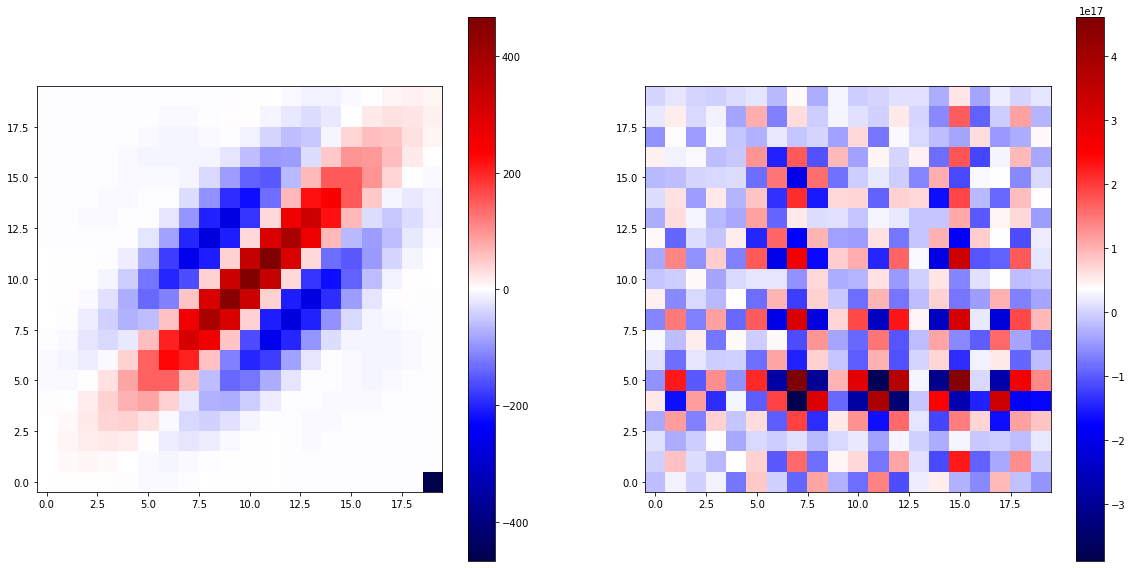

In [35]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_inverse_of_pinv, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [36]:
cov_mat_evals = np.linalg.eigvals( hist_cov_mat )

In [37]:
for evi in range( len(cov_mat_evals) ) :
    evratio = cov_mat_evals[evi]/cov_mat_evals[0]
    print(' %3d : %12.5f  %.7f' % (evi, cov_mat_evals[evi], evratio), end='')
    if evratio < 0.001 : print(' * ', end='')
    print()

   0 :   1445.12005  1.0000000
   1 :   1388.84590  0.9610592
   2 :    455.97165  0.3155251
   3 :    334.11401  0.2312016
   4 :    116.02345  0.0802864
   5 :     65.74204  0.0454924
   6 :     22.73653  0.0157333
   7 :     11.71211  0.0081046
   8 :      3.68776  0.0025519
   9 :      1.50633  0.0010424
  10 :      0.59356  0.0004107 * 
  11 :      0.22956  0.0001589 * 
  12 :      0.08210  0.0000568 * 
  13 :      0.04461  0.0000309 * 
  14 :      0.02827  0.0000196 * 
  15 :      0.00936  0.0000065 * 
  16 :      0.00032  0.0000002 * 
  17 :      0.00142  0.0000010 * 
  18 :      0.00588  0.0000041 * 
  19 :      0.00409  0.0000028 * 


In [38]:
U, S, Vh = np.linalg.svd( hist_cov_mat, full_matrices=True)

In [39]:
S

array([1.44512005e+03, 1.38884590e+03, 4.55971652e+02, 3.34114009e+02,
       1.16023452e+02, 6.57420379e+01, 2.27365309e+01, 1.17121063e+01,
       3.68775876e+00, 1.50633032e+00, 5.93564151e-01, 2.29561140e-01,
       8.20992725e-02, 4.46145026e-02, 2.82742542e-02, 9.35716465e-03,
       5.88023183e-03, 4.08975787e-03, 1.42430149e-03, 3.19591751e-04])



 N rows = 4, N cols = 5


<function matplotlib.pyplot.show(close=None, block=None)>

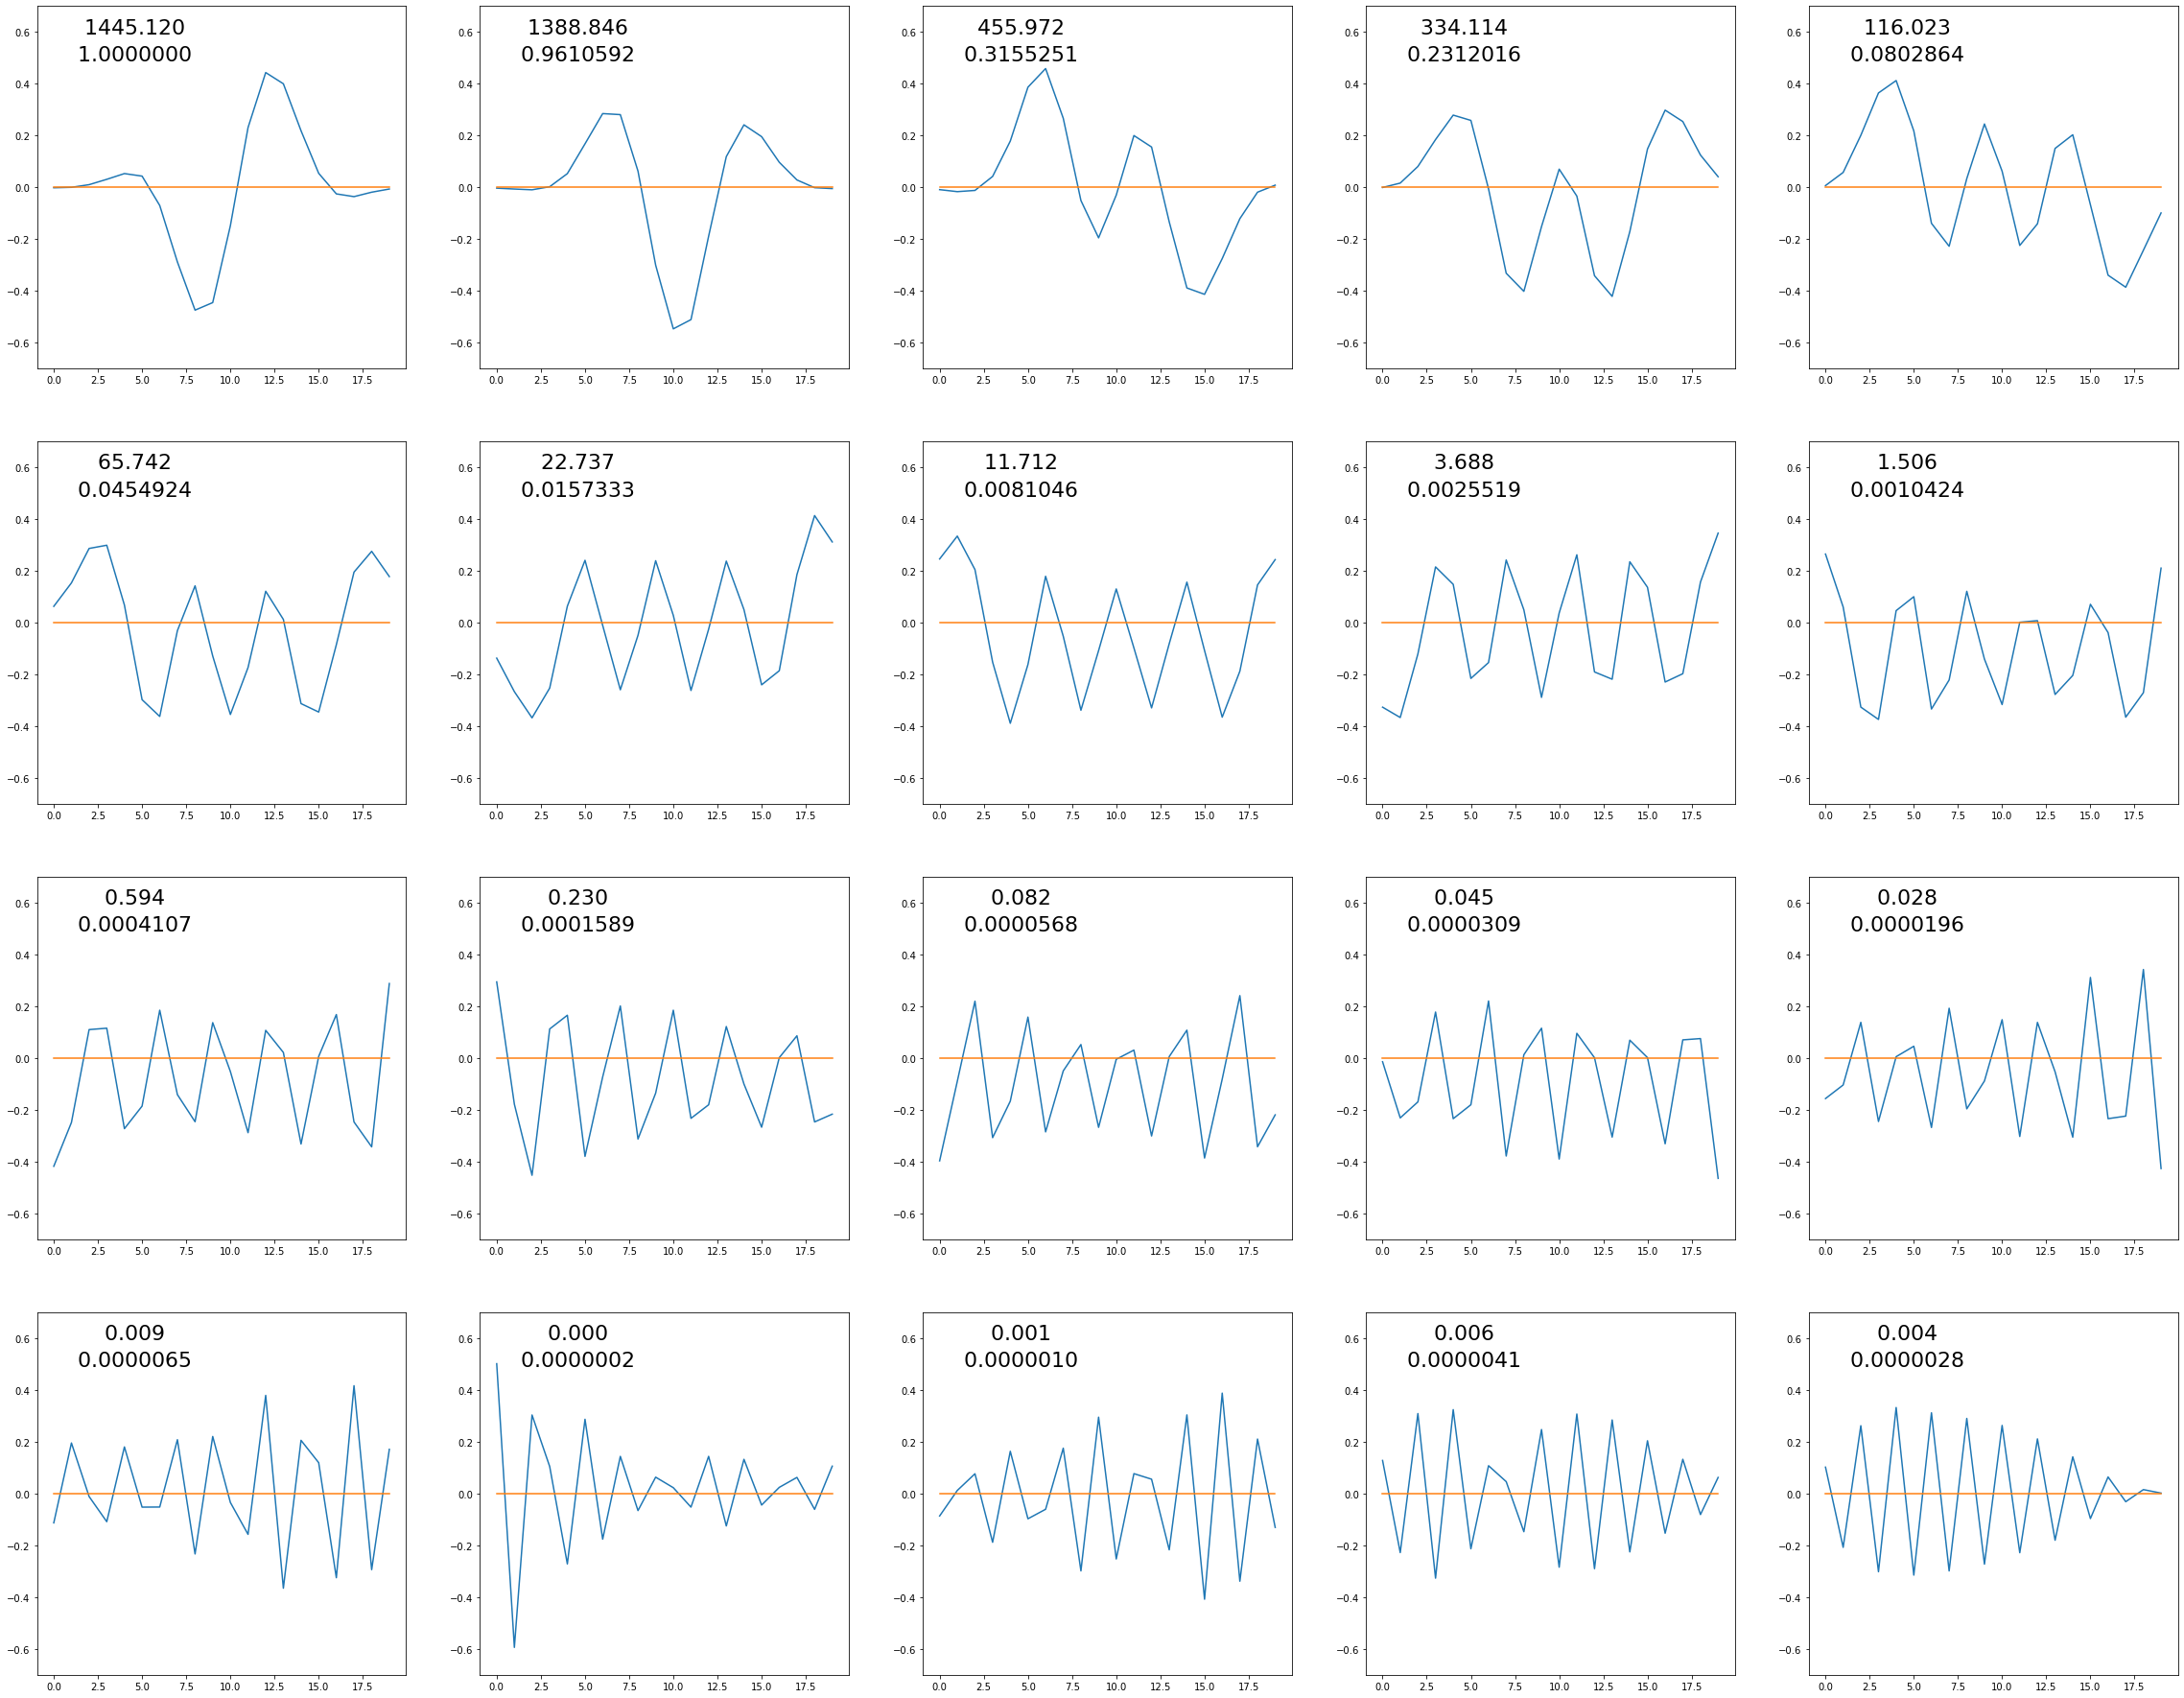

In [40]:
plot_ncols = 5
plot_nrows = int( len(cov_mat_evals) / plot_ncols )
print('\n\n N rows = %d, N cols = %d' % (plot_nrows, plot_ncols))

fig,ax = plt.subplots( plot_nrows, plot_ncols, figsize=(plot_ncols*8, plot_nrows*8))

for ri in range( plot_nrows ) :
    for ci in range( plot_ncols ) :
        
        evi = plot_ncols*ri + ci
        
        axi = ax[ri,ci]
        
        axi.plot(U[:,evi])
        
        axi.plot( np.zeros( len(cov_mat_evals) ))

        ymax = 0.7
        axi.set_ylim( -1*ymax, ymax )
        
        axi.text( 1, ymax * 0.85 , '%10.3f' % cov_mat_evals[evi], fontsize=22 )
        
        evratio = cov_mat_evals[evi]/cov_mat_evals[0]
        
        axi.text( 1, ymax * 0.70 , '%10.7f' % evratio, fontsize=22 )
        
plt.show

## Visualize what goes in to chi2 calc

In [41]:
vis_mat_pinv = np.zeros( shape=(hist_nbins, hist_nbins))
vis_mat_inv = np.zeros( shape=(hist_nbins, hist_nbins))

for i in range( hist_nbins ) :
    for j in range( hist_nbins ) :
        sigma_i = np.sqrt( hist_cov_mat[i,i] )
        sigma_j = np.sqrt( hist_cov_mat[j,j] )
        if i == j :
            vis_mat_pinv[i,i] = sigma_i * sigma_i * hist_cov_pinv[i,i]
            vis_mat_inv[i,i] = sigma_i * sigma_i * hist_cov_inv[i,i]
        else :
            vis_mat_pinv[i,j] = 2. * sigma_i * sigma_j * hist_cov_pinv[i,j]
            vis_mat_inv[i,j] = 2. * sigma_i * sigma_j * hist_cov_inv[i,j]


vis_pinv_min = np.min(vis_mat_pinv)
vis_pinv_max = np.max(vis_mat_pinv)
print('\n\n min and max of vis matrix, pinv :  %.2f  %.2f\n\n' % (vis_pinv_min, vis_pinv_max))
vis_mat_pinv_copy = np.copy( vis_mat_pinv )
vis_mat_pinv_copy[0,hist_nbins-1] = -1. * vis_pinv_max


vis_inv_min = np.min(vis_mat_inv)
vis_inv_max = np.max(vis_mat_inv)
print('\n\n min and max of vis matrix, inv :  %.2f  %.2f\n\n' % (vis_inv_min, vis_inv_max))
vis_mat_inv_copy = np.copy( vis_mat_inv )
vis_mat_inv_copy[0,hist_nbins-1] = -1. * vis_inv_max





 min and max of vis matrix, pinv :  -24.84  46.34




 min and max of vis matrix, inv :  -264918.18  239554.27




<function matplotlib.pyplot.show(close=None, block=None)>

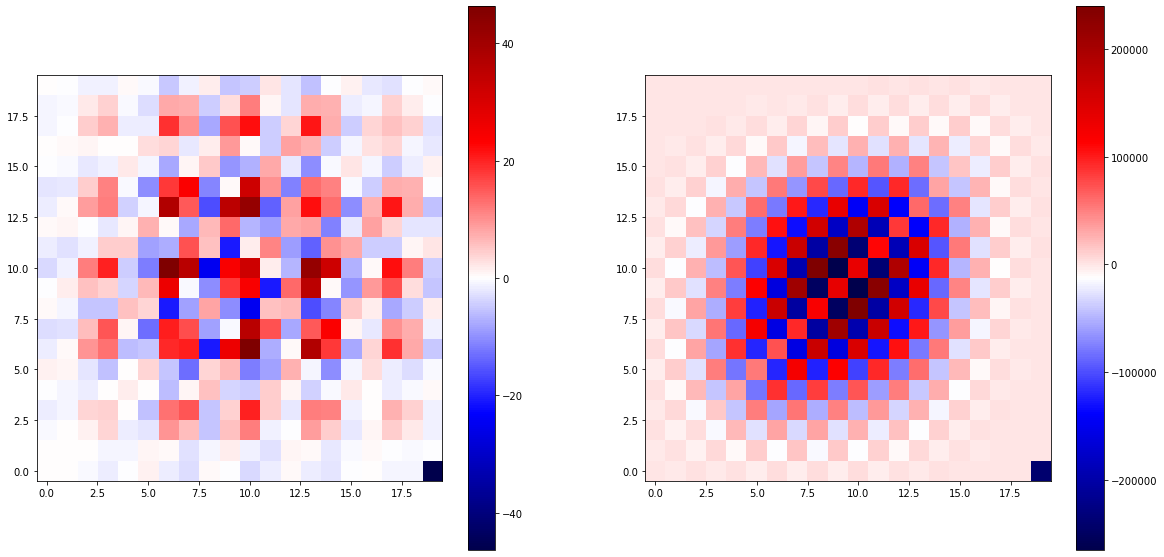

In [42]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_vis_mat_pinv = ax[0].imshow(vis_mat_pinv_copy,  cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_vis_mat_pinv, ax=ax[0] )

im_vis_mat_inv = ax[1].imshow(vis_mat_inv_copy,  cmap='seismic', origin='lower')
ax[1].figure.colorbar( im_vis_mat_inv, ax=ax[1] )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

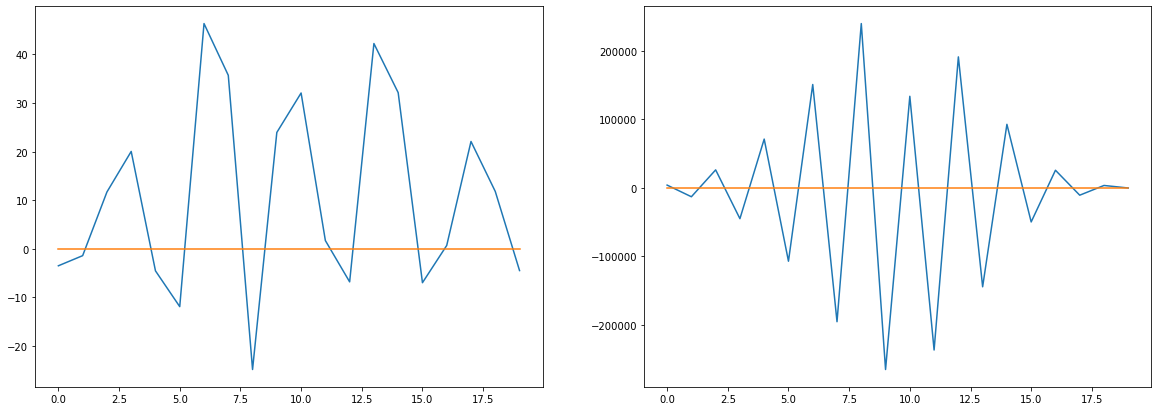

In [43]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,7))

ibin = 10

ax[0].plot( vis_mat_pinv[:,ibin])
ax[0].plot( np.zeros( hist_nbins ))

ax[1].plot( vis_mat_inv[:,ibin])
ax[1].plot( np.zeros( hist_nbins ))

plt.show

In [44]:
for bi in range( hist_nbins ) :
    for bj in range( hist_nbins ) :
        print('  %3d, %3d:   inv = %8.3f   pinv = %8.3f' % (bi, bj, hist_cov_inv[bi,bj], hist_cov_pinv[bi,bj]))

    0,   0:   inv =   92.811   pinv =    0.081
    0,   1:   inv = -138.483   pinv =    0.052
    0,   2:   inv =  132.125   pinv =   -0.040
    0,   3:   inv = -108.049   pinv =   -0.086
    0,   4:   inv =  106.327   pinv =   -0.013
    0,   5:   inv =  -93.242   pinv =    0.032
    0,   6:   inv =   97.561   pinv =   -0.042
    0,   7:   inv =  -85.229   pinv =   -0.060
    0,   8:   inv =   82.674   pinv =    0.010
    0,   9:   inv =  -66.689   pinv =   -0.003
    0,  10:   inv =   64.946   pinv =   -0.057
    0,  11:   inv =  -48.041   pinv =   -0.023
    0,  12:   inv =   47.511   pinv =    0.012
    0,  13:   inv =  -33.110   pinv =   -0.033
    0,  14:   inv =   28.040   pinv =   -0.054
    0,  15:   inv =   -9.427   pinv =   -0.001
    0,  16:   inv =    5.758   pinv =    0.007
    0,  17:   inv =    9.308   pinv =   -0.052
    0,  18:   inv =   -9.183   pinv =   -0.061
    0,  19:   inv =   18.632   pinv =    0.010
    1,   0:   inv = -138.483   pinv =    0.052
    1,   1:  

In [45]:
hist_cov_mat_diagonal = np.copy( hist_cov_mat )
for bi in range(hist_nbins) :
    for bj in range(hist_nbins) :
        if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

In [46]:
hist_cov_mat_diagonal

array([[  2.08633707,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   5.67809879,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  16.44976343,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  

In [47]:
hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )
print(hist_cov_inv_diagonal)

[[0.47930893 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.17611529 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.06079115 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.0269919  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.01414809 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


## Set up a Minuit fit

Used this example from Glen Cowan as a starting point: https://github.com/KMISchool2022/histFit/blob/main/histFit.ipynb


In [48]:
import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2

xMin = hist_xlow
xMax = hist_xhigh

In [49]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

In [50]:
# Initialize Minuit and set up fit:
theta = 1
mu = 0.2
sigma2 = 0.81
#fitType = 'bin center approximation'
#fitType = 'integral within bin'

parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
parname = ['theta', 'mu', 'sigma2']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
parfix  = [False, False, False]            # change to fix/free param.
parlim  = [(0.5, 1.5), (None, None), (0., None)]

chisq = ChiSquared(boot_hist_content[0,:], hist_bin_edges, hist_cov_pinv, fitType, 1)
chisq_diag = ChiSquared(boot_hist_content[0,:], hist_bin_edges, hist_cov_inv_diagonal, fitType, 1)


m = Minuit(chisq, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 1.0                      # errors from chi2 = chi2min + 1


m_diag = Minuit(chisq_diag, parin, name=parname)
m_diag.errors = parstep
m_diag.fixed = parfix
m_diag.limits = parlim
m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1



 setData:
  numVal:       9982.7  numBins = 20
  binLowEdge:   fitType: integral within bin
[-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]


 setData:
  numVal:       9982.7  numBins = 20
  binLowEdge:   fitType: integral within bin
[-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]


In [51]:
# do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
parhat = m.values                                 # max-likelihood estimates
sigma_parhat = m.errors                           # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.

m_diag.migrad()                                        # minimize -logL
parhat_diag = m_diag.values                                 # max-likelihood estimates
sigma_parhat_diag = m_diag.errors                           # standard deviations
cov_diag = m_diag.covariance                                # covariance matrix
rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.




In [52]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:

        print(' %2d %-10s  =  %7.4f +/- %7.4f ,   diagonal cov result = %7.4f +/- %7.4f' %
              (i, m.parameters[i], parhat[i], sigma_parhat[i],
              parhat_diag[i], sigma_parhat_diag[i])
             )
            
            
            
print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not m.fixed[i]:
        for j in range(m.npar):
            if not m.fixed[j]:
                print(i, j, "{:9.6f}".format(cov[i,j]), "{:9.6f}".format(rho[i,j]))

# Retrieve minimized chi-squared, etc.
ndof = hist_nbins - m.nfit - 1           # for fixed numVal
chi2min = chisq(parhat)
print ("chi2min = ", chi2min, ",     ndof = ", ndof)
pval = chi2.sf(chi2min, ndof)
print ("pval = ", pval)

par index, name, estimate, standard deviation:
  0 theta       =   0.9968 +/-  0.0010 ,   diagonal cov result =  1.0007 +/-  0.0062
  1 mu          =   0.1882 +/-  0.0105 ,   diagonal cov result =  0.1882 +/-  0.0060
  2 sigma2      =   0.8015 +/-  0.0157 ,   diagonal cov result =  0.8148 +/-  0.0079

free par indices, covariance, correlation coeff.:
0 0  0.000001  1.000000
0 1 -0.000001 -0.075063
0 2  0.000002  0.141673
1 0 -0.000001 -0.075063
1 1  0.000111  1.000000
1 2  0.000011  0.068771
2 0  0.000002  0.141673
2 1  0.000011  0.068771
2 2  0.000246  1.000000
chi2min =  4.216321612625848 ,     ndof =  16
pval =  0.9984779169170841


In [53]:
boot_hist_content.shape

(5000, 20)

In [54]:
len(boot_hist_content)

5000

In [55]:
nfits = len(boot_hist_content)
#nfits = 500
if nfits > 5000 : nfits = 5000

In [56]:

chi2_fit_mu_val = np.zeros( nfits )
chi2_fit_mu_err = np.zeros( nfits )

chi2_fit_sig2_val = np.zeros( nfits )
chi2_fit_sig2_err = np.zeros( nfits )

chi2_fit_diag_mu_val = np.zeros( nfits )
chi2_fit_diag_mu_err = np.zeros( nfits )

chi2_fit_diag_sig2_val = np.zeros( nfits )
chi2_fit_diag_sig2_err = np.zeros( nfits )





for si in range( nfits ) :
    
    # Initialize Minuit and set up fit:
    theta = 1
    mu = 0.2
    sigma2 = 0.81
    #fitType = 'full cov'

    parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
    parname = ['theta', 'mu', 'sigma2']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
    parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
    parfix  = [False, False, False]            # change to fix/free param.
    parlim  = [(0.5, 1.5), (None, None), (0., None)]

    chisq = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_pinv, fitType)
    chisq_diag = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_inv_diagonal, fitType)


    m = Minuit(chisq, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 1.0                      # errors from chi2 = chi2min + 1


    m_diag = Minuit(chisq_diag, parin, name=parname)
    m_diag.errors = parstep
    m_diag.fixed = parfix
    m_diag.limits = parlim
    m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    
    
    
    # do the fit, get errors, extract results
    m.migrad()                                        # minimize -logL
    parhat = m.values                                 # max-likelihood estimates
    sigma_parhat = m.errors                           # standard deviations
    cov = m.covariance                                # covariance matrix
    rho = m.covariance.correlation()                  # correlation coeffs.

    m_diag.migrad()                                        # minimize -logL
    parhat_diag = m_diag.values                                 # max-likelihood estimates
    sigma_parhat_diag = m_diag.errors                           # standard deviations
    cov_diag = m_diag.covariance                                # covariance matrix
    rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.

    
    chi2_fit_mu_val[si] = parhat[1]
    chi2_fit_mu_err[si] = sigma_parhat[1]

    chi2_fit_sig2_val[si] = parhat[2]
    chi2_fit_sig2_err[si] = sigma_parhat[2]

    
    chi2_fit_diag_mu_val[si] = parhat_diag[1]
    chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

    chi2_fit_diag_sig2_val[si] = parhat_diag[2]
    chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]

    
    

    
    
    
    print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
          (si, 
           parhat[1], sigma_parhat[1],
           parhat_diag[1], sigma_parhat_diag[1],
           parhat[2], sigma_parhat[2],
           parhat_diag[2], sigma_parhat_diag[2],
          )
         )
    

   0 : mu   0.1882 +/-   0.0105  (  0.1882 +/-   0.0060)    sig2   0.8015 +/-   0.0157  (  0.8148 +/-   0.0079)
   1 : mu   0.1923 +/-   0.0105  (  0.1927 +/-   0.0059)    sig2   0.7939 +/-   0.0158  (  0.8025 +/-   0.0080)
   2 : mu   0.1875 +/-   0.0105  (  0.1889 +/-   0.0060)    sig2   0.8207 +/-   0.0159  (  0.8281 +/-   0.0081)
   3 : mu   0.2012 +/-   0.0105  (  0.2024 +/-   0.0059)    sig2   0.7826 +/-   0.0160  (  0.7904 +/-   0.0081)
   4 : mu   0.2042 +/-   0.0105  (  0.2056 +/-   0.0059)    sig2   0.7865 +/-   0.0155  (  0.7996 +/-   0.0079)
   5 : mu   0.1933 +/-   0.0105  (  0.1941 +/-   0.0060)    sig2   0.8227 +/-   0.0160  (  0.8340 +/-   0.0081)
   6 : mu   0.1997 +/-   0.0105  (  0.2005 +/-   0.0060)    sig2   0.8075 +/-   0.0160  (  0.8193 +/-   0.0081)
   7 : mu   0.1907 +/-   0.0105  (  0.1914 +/-   0.0059)    sig2   0.8039 +/-   0.0159  (  0.8103 +/-   0.0080)
   8 : mu   0.1950 +/-   0.0105  (  0.1961 +/-   0.0059)    sig2   0.7923 +/-   0.0155  (  0.8037 +/-   

 136 : mu   0.2065 +/-   0.0105  (  0.2073 +/-   0.0059)    sig2   0.7941 +/-   0.0157  (  0.8045 +/-   0.0080)
 137 : mu   0.1933 +/-   0.0105  (  0.1929 +/-   0.0059)    sig2   0.7975 +/-   0.0160  (  0.8058 +/-   0.0081)
 138 : mu   0.2032 +/-   0.0105  (  0.2032 +/-   0.0059)    sig2   0.7941 +/-   0.0159  (  0.8025 +/-   0.0080)
 139 : mu   0.2271 +/-   0.0105  (  0.2253 +/-   0.0059)    sig2   0.7802 +/-   0.0156  (  0.7884 +/-   0.0079)
 140 : mu   0.1705 +/-   0.0105  (  0.1709 +/-   0.0060)    sig2   0.7933 +/-   0.0156  (  0.8106 +/-   0.0079)
 141 : mu   0.2053 +/-   0.0105  (  0.2049 +/-   0.0060)    sig2   0.8164 +/-   0.0157  (  0.8272 +/-   0.0080)
 142 : mu   0.1950 +/-   0.0105  (  0.1975 +/-   0.0059)    sig2   0.7867 +/-   0.0157  (  0.7981 +/-   0.0080)
 143 : mu   0.2239 +/-   0.0105  (  0.2244 +/-   0.0060)    sig2   0.8119 +/-   0.0159  (  0.8164 +/-   0.0081)
 144 : mu   0.2040 +/-   0.0105  (  0.2050 +/-   0.0060)    sig2   0.8235 +/-   0.0157  (  0.8294 +/-   

 242 : mu   0.1980 +/-   0.0105  (  0.1997 +/-   0.0059)    sig2   0.7935 +/-   0.0156  (  0.8045 +/-   0.0079)
 243 : mu   0.1977 +/-   0.0105  (  0.1982 +/-   0.0059)    sig2   0.7990 +/-   0.0162  (  0.8075 +/-   0.0082)
 244 : mu   0.1946 +/-   0.0105  (  0.1952 +/-   0.0059)    sig2   0.7854 +/-   0.0156  (  0.7950 +/-   0.0079)
 245 : mu   0.2065 +/-   0.0105  (  0.2063 +/-   0.0059)    sig2   0.7937 +/-   0.0158  (  0.8044 +/-   0.0080)
 246 : mu   0.1851 +/-   0.0105  (  0.1864 +/-   0.0060)    sig2   0.8321 +/-   0.0160  (  0.8407 +/-   0.0081)
 247 : mu   0.1807 +/-   0.0105  (  0.1823 +/-   0.0060)    sig2   0.8118 +/-   0.0155  (  0.8210 +/-   0.0079)
 248 : mu   0.2090 +/-   0.0105  (  0.2115 +/-   0.0059)    sig2   0.7981 +/-   0.0156  (  0.8094 +/-   0.0080)
 249 : mu   0.2026 +/-   0.0105  (  0.2056 +/-   0.0060)    sig2   0.8157 +/-   0.0160  (  0.8222 +/-   0.0081)
 250 : mu   0.1924 +/-   0.0105  (  0.1917 +/-   0.0059)    sig2   0.7789 +/-   0.0154  (  0.7932 +/-   

 353 : mu   0.1839 +/-   0.0105  (  0.1853 +/-   0.0060)    sig2   0.8529 +/-   0.0158  (  0.8626 +/-   0.0080)
 354 : mu   0.2080 +/-   0.0105  (  0.2093 +/-   0.0059)    sig2   0.7619 +/-   0.0153  (  0.7681 +/-   0.0078)
 355 : mu   0.1900 +/-   0.0105  (  0.1917 +/-   0.0059)    sig2   0.7946 +/-   0.0154  (  0.8037 +/-   0.0078)
 356 : mu   0.1924 +/-   0.0105  (  0.1947 +/-   0.0060)    sig2   0.8115 +/-   0.0154  (  0.8216 +/-   0.0078)
 357 : mu   0.1814 +/-   0.0105  (  0.1824 +/-   0.0059)    sig2   0.8007 +/-   0.0157  (  0.8136 +/-   0.0079)
 358 : mu   0.2175 +/-   0.0105  (  0.2179 +/-   0.0059)    sig2   0.7821 +/-   0.0155  (  0.7963 +/-   0.0079)
 359 : mu   0.1903 +/-   0.0105  (  0.1919 +/-   0.0060)    sig2   0.8173 +/-   0.0158  (  0.8222 +/-   0.0080)
 360 : mu   0.1967 +/-   0.0105  (  0.1969 +/-   0.0059)    sig2   0.7961 +/-   0.0154  (  0.8061 +/-   0.0079)
 361 : mu   0.2063 +/-   0.0105  (  0.2054 +/-   0.0059)    sig2   0.7975 +/-   0.0158  (  0.8086 +/-   

 463 : mu   0.1937 +/-   0.0105  (  0.1940 +/-   0.0059)    sig2   0.7866 +/-   0.0154  (  0.7974 +/-   0.0078)
 464 : mu   0.1883 +/-   0.0105  (  0.1885 +/-   0.0060)    sig2   0.8139 +/-   0.0159  (  0.8237 +/-   0.0081)
 465 : mu   0.2123 +/-   0.0105  (  0.2134 +/-   0.0059)    sig2   0.7785 +/-   0.0156  (  0.7894 +/-   0.0080)
 466 : mu   0.2027 +/-   0.0105  (  0.2031 +/-   0.0059)    sig2   0.7991 +/-   0.0158  (  0.8078 +/-   0.0079)
 467 : mu   0.1792 +/-   0.0105  (  0.1814 +/-   0.0059)    sig2   0.7972 +/-   0.0157  (  0.8085 +/-   0.0079)
 468 : mu   0.2083 +/-   0.0105  (  0.2082 +/-   0.0060)    sig2   0.8106 +/-   0.0159  (  0.8168 +/-   0.0081)
 469 : mu   0.1998 +/-   0.0105  (  0.2014 +/-   0.0060)    sig2   0.8054 +/-   0.0155  (  0.8173 +/-   0.0079)
 470 : mu   0.1920 +/-   0.0105  (  0.1914 +/-   0.0060)    sig2   0.8154 +/-   0.0158  (  0.8283 +/-   0.0080)
 471 : mu   0.1922 +/-   0.0105  (  0.1929 +/-   0.0059)    sig2   0.8030 +/-   0.0158  (  0.8115 +/-   

 573 : mu   0.2065 +/-   0.0105  (  0.2082 +/-   0.0059)    sig2   0.7852 +/-   0.0160  (  0.7958 +/-   0.0081)
 574 : mu   0.1899 +/-   0.0106  (  0.1899 +/-   0.0060)    sig2   0.8453 +/-   0.0161  (  0.8576 +/-   0.0081)
 575 : mu   0.2002 +/-   0.0105  (  0.1993 +/-   0.0059)    sig2   0.7874 +/-   0.0152  (  0.7998 +/-   0.0077)
 576 : mu   0.2199 +/-   0.0105  (  0.2186 +/-   0.0059)    sig2   0.7801 +/-   0.0155  (  0.7926 +/-   0.0079)
 577 : mu   0.1852 +/-   0.0105  (  0.1873 +/-   0.0059)    sig2   0.8030 +/-   0.0157  (  0.8161 +/-   0.0080)
 578 : mu   0.2012 +/-   0.0105  (  0.1998 +/-   0.0059)    sig2   0.7919 +/-   0.0159  (  0.8065 +/-   0.0081)
 579 : mu   0.1995 +/-   0.0105  (  0.2001 +/-   0.0059)    sig2   0.8013 +/-   0.0159  (  0.8069 +/-   0.0080)
 580 : mu   0.2094 +/-   0.0105  (  0.2095 +/-   0.0060)    sig2   0.8320 +/-   0.0159  (  0.8416 +/-   0.0080)
 581 : mu   0.1994 +/-   0.0105  (  0.2004 +/-   0.0059)    sig2   0.8171 +/-   0.0159  (  0.8202 +/-   

 683 : mu   0.2095 +/-   0.0105  (  0.2104 +/-   0.0060)    sig2   0.8127 +/-   0.0159  (  0.8251 +/-   0.0081)
 684 : mu   0.2040 +/-   0.0105  (  0.2048 +/-   0.0059)    sig2   0.7954 +/-   0.0156  (  0.8066 +/-   0.0080)
 685 : mu   0.2075 +/-   0.0105  (  0.2078 +/-   0.0059)    sig2   0.8022 +/-   0.0159  (  0.8068 +/-   0.0080)
 686 : mu   0.2147 +/-   0.0105  (  0.2153 +/-   0.0059)    sig2   0.8062 +/-   0.0157  (  0.8141 +/-   0.0080)
 687 : mu   0.1927 +/-   0.0105  (  0.1943 +/-   0.0059)    sig2   0.8119 +/-   0.0158  (  0.8186 +/-   0.0079)
 688 : mu   0.2098 +/-   0.0105  (  0.2102 +/-   0.0059)    sig2   0.7918 +/-   0.0156  (  0.8012 +/-   0.0079)
 689 : mu   0.1799 +/-   0.0105  (  0.1787 +/-   0.0060)    sig2   0.8199 +/-   0.0159  (  0.8291 +/-   0.0080)
 690 : mu   0.1929 +/-   0.0105  (  0.1935 +/-   0.0059)    sig2   0.7853 +/-   0.0155  (  0.7993 +/-   0.0079)
 691 : mu   0.2295 +/-   0.0105  (  0.2295 +/-   0.0060)    sig2   0.8159 +/-   0.0160  (  0.8216 +/-   

 793 : mu   0.2077 +/-   0.0105  (  0.2094 +/-   0.0060)    sig2   0.8222 +/-   0.0158  (  0.8345 +/-   0.0080)
 794 : mu   0.2263 +/-   0.0105  (  0.2274 +/-   0.0060)    sig2   0.8276 +/-   0.0163  (  0.8337 +/-   0.0083)
 795 : mu   0.1939 +/-   0.0105  (  0.1935 +/-   0.0059)    sig2   0.7888 +/-   0.0157  (  0.7965 +/-   0.0080)
 796 : mu   0.2191 +/-   0.0105  (  0.2215 +/-   0.0060)    sig2   0.8015 +/-   0.0158  (  0.8110 +/-   0.0080)
 797 : mu   0.1832 +/-   0.0104  (  0.1837 +/-   0.0059)    sig2   0.7690 +/-   0.0157  (  0.7738 +/-   0.0079)
 798 : mu   0.2158 +/-   0.0105  (  0.2177 +/-   0.0060)    sig2   0.8206 +/-   0.0158  (  0.8339 +/-   0.0081)
 799 : mu   0.1911 +/-   0.0105  (  0.1911 +/-   0.0060)    sig2   0.8062 +/-   0.0156  (  0.8165 +/-   0.0079)
 800 : mu   0.1978 +/-   0.0105  (  0.2000 +/-   0.0060)    sig2   0.8062 +/-   0.0155  (  0.8163 +/-   0.0079)
 801 : mu   0.2032 +/-   0.0105  (  0.2034 +/-   0.0059)    sig2   0.7922 +/-   0.0159  (  0.8036 +/-   

 903 : mu   0.2164 +/-   0.0105  (  0.2185 +/-   0.0059)    sig2   0.7869 +/-   0.0156  (  0.8002 +/-   0.0080)
 904 : mu   0.2013 +/-   0.0105  (  0.2021 +/-   0.0059)    sig2   0.7836 +/-   0.0156  (  0.7935 +/-   0.0078)
 905 : mu   0.1821 +/-   0.0105  (  0.1831 +/-   0.0059)    sig2   0.7672 +/-   0.0153  (  0.7810 +/-   0.0078)
 906 : mu   0.1968 +/-   0.0105  (  0.1977 +/-   0.0059)    sig2   0.7965 +/-   0.0159  (  0.8007 +/-   0.0080)
 907 : mu   0.2016 +/-   0.0105  (  0.2017 +/-   0.0060)    sig2   0.8073 +/-   0.0155  (  0.8216 +/-   0.0079)
 908 : mu   0.1921 +/-   0.0105  (  0.1916 +/-   0.0060)    sig2   0.8107 +/-   0.0156  (  0.8217 +/-   0.0079)
 909 : mu   0.1991 +/-   0.0105  (  0.1996 +/-   0.0060)    sig2   0.8104 +/-   0.0158  (  0.8202 +/-   0.0080)
 910 : mu   0.2195 +/-   0.0105  (  0.2171 +/-   0.0060)    sig2   0.8070 +/-   0.0161  (  0.8087 +/-   0.0081)
 911 : mu   0.2030 +/-   0.0105  (  0.2037 +/-   0.0059)    sig2   0.7986 +/-   0.0159  (  0.8076 +/-   

 1013 : mu   0.2051 +/-   0.0105  (  0.2039 +/-   0.0060)    sig2   0.8150 +/-   0.0159  (  0.8236 +/-   0.0080)
 1014 : mu   0.1798 +/-   0.0105  (  0.1811 +/-   0.0059)    sig2   0.7956 +/-   0.0153  (  0.8055 +/-   0.0078)
 1015 : mu   0.2190 +/-   0.0105  (  0.2193 +/-   0.0060)    sig2   0.8308 +/-   0.0160  (  0.8365 +/-   0.0081)
 1016 : mu   0.1872 +/-   0.0105  (  0.1883 +/-   0.0059)    sig2   0.8109 +/-   0.0157  (  0.8217 +/-   0.0080)
 1017 : mu   0.1846 +/-   0.0105  (  0.1848 +/-   0.0059)    sig2   0.7943 +/-   0.0155  (  0.8044 +/-   0.0078)
 1018 : mu   0.2026 +/-   0.0105  (  0.2034 +/-   0.0059)    sig2   0.7993 +/-   0.0160  (  0.8086 +/-   0.0081)
 1019 : mu   0.1951 +/-   0.0105  (  0.1951 +/-   0.0060)    sig2   0.8119 +/-   0.0159  (  0.8202 +/-   0.0080)
 1020 : mu   0.2335 +/-   0.0105  (  0.2332 +/-   0.0059)    sig2   0.7935 +/-   0.0159  (  0.8038 +/-   0.0081)
 1021 : mu   0.1898 +/-   0.0105  (  0.1902 +/-   0.0059)    sig2   0.7957 +/-   0.0157  (  0.80

 1123 : mu   0.2032 +/-   0.0105  (  0.2024 +/-   0.0059)    sig2   0.7964 +/-   0.0158  (  0.8066 +/-   0.0080)
 1124 : mu   0.1968 +/-   0.0105  (  0.1950 +/-   0.0060)    sig2   0.8055 +/-   0.0162  (  0.8136 +/-   0.0081)
 1125 : mu   0.2115 +/-   0.0105  (  0.2124 +/-   0.0060)    sig2   0.8230 +/-   0.0157  (  0.8322 +/-   0.0079)
 1126 : mu   0.2175 +/-   0.0105  (  0.2183 +/-   0.0060)    sig2   0.8202 +/-   0.0156  (  0.8327 +/-   0.0079)
 1127 : mu   0.2033 +/-   0.0105  (  0.2032 +/-   0.0060)    sig2   0.8118 +/-   0.0157  (  0.8189 +/-   0.0079)
 1128 : mu   0.1980 +/-   0.0105  (  0.1966 +/-   0.0059)    sig2   0.7898 +/-   0.0156  (  0.7999 +/-   0.0080)
 1129 : mu   0.1732 +/-   0.0105  (  0.1747 +/-   0.0060)    sig2   0.8104 +/-   0.0155  (  0.8174 +/-   0.0078)
 1130 : mu   0.1726 +/-   0.0105  (  0.1742 +/-   0.0059)    sig2   0.7762 +/-   0.0156  (  0.7897 +/-   0.0079)
 1131 : mu   0.2007 +/-   0.0105  (  0.2002 +/-   0.0060)    sig2   0.8069 +/-   0.0160  (  0.81

 1233 : mu   0.2126 +/-   0.0105  (  0.2133 +/-   0.0059)    sig2   0.7766 +/-   0.0153  (  0.7866 +/-   0.0077)
 1234 : mu   0.1997 +/-   0.0105  (  0.2015 +/-   0.0059)    sig2   0.7972 +/-   0.0161  (  0.8088 +/-   0.0082)
 1235 : mu   0.2062 +/-   0.0105  (  0.2080 +/-   0.0060)    sig2   0.8398 +/-   0.0163  (  0.8421 +/-   0.0082)
 1236 : mu   0.2241 +/-   0.0105  (  0.2213 +/-   0.0059)    sig2   0.7918 +/-   0.0161  (  0.7967 +/-   0.0081)
 1237 : mu   0.2147 +/-   0.0105  (  0.2171 +/-   0.0060)    sig2   0.8274 +/-   0.0156  (  0.8382 +/-   0.0079)
 1238 : mu   0.2072 +/-   0.0105  (  0.2084 +/-   0.0059)    sig2   0.7807 +/-   0.0159  (  0.7904 +/-   0.0080)
 1239 : mu   0.2150 +/-   0.0105  (  0.2161 +/-   0.0060)    sig2   0.8190 +/-   0.0155  (  0.8316 +/-   0.0079)
 1240 : mu   0.1882 +/-   0.0105  (  0.1864 +/-   0.0060)    sig2   0.8018 +/-   0.0157  (  0.8104 +/-   0.0079)
 1241 : mu   0.1912 +/-   0.0105  (  0.1916 +/-   0.0059)    sig2   0.7777 +/-   0.0156  (  0.78

 1342 : mu   0.1972 +/-   0.0105  (  0.1975 +/-   0.0060)    sig2   0.8168 +/-   0.0162  (  0.8204 +/-   0.0082)
 1343 : mu   0.2069 +/-   0.0105  (  0.2069 +/-   0.0060)    sig2   0.8138 +/-   0.0159  (  0.8282 +/-   0.0080)
 1344 : mu   0.2043 +/-   0.0105  (  0.2063 +/-   0.0060)    sig2   0.8376 +/-   0.0160  (  0.8439 +/-   0.0081)
 1345 : mu   0.2240 +/-   0.0105  (  0.2236 +/-   0.0059)    sig2   0.8048 +/-   0.0158  (  0.8074 +/-   0.0080)
 1346 : mu   0.1874 +/-   0.0105  (  0.1901 +/-   0.0059)    sig2   0.7975 +/-   0.0152  (  0.8142 +/-   0.0077)
 1347 : mu   0.2020 +/-   0.0105  (  0.2012 +/-   0.0059)    sig2   0.7794 +/-   0.0158  (  0.7894 +/-   0.0080)
 1348 : mu   0.1892 +/-   0.0105  (  0.1898 +/-   0.0060)    sig2   0.8106 +/-   0.0159  (  0.8206 +/-   0.0080)
 1349 : mu   0.1775 +/-   0.0105  (  0.1781 +/-   0.0059)    sig2   0.8015 +/-   0.0159  (  0.8092 +/-   0.0080)
 1350 : mu   0.1962 +/-   0.0105  (  0.1999 +/-   0.0060)    sig2   0.8167 +/-   0.0158  (  0.82

 1452 : mu   0.2051 +/-   0.0105  (  0.2068 +/-   0.0060)    sig2   0.8157 +/-   0.0159  (  0.8242 +/-   0.0081)
 1453 : mu   0.2018 +/-   0.0105  (  0.2015 +/-   0.0059)    sig2   0.7843 +/-   0.0157  (  0.7947 +/-   0.0080)
 1454 : mu   0.1911 +/-   0.0105  (  0.1925 +/-   0.0060)    sig2   0.8136 +/-   0.0155  (  0.8238 +/-   0.0078)
 1455 : mu   0.2081 +/-   0.0105  (  0.2088 +/-   0.0059)    sig2   0.8031 +/-   0.0155  (  0.8120 +/-   0.0079)
 1456 : mu   0.1942 +/-   0.0105  (  0.1947 +/-   0.0059)    sig2   0.7974 +/-   0.0157  (  0.8076 +/-   0.0079)
 1457 : mu   0.2146 +/-   0.0105  (  0.2150 +/-   0.0060)    sig2   0.8166 +/-   0.0158  (  0.8274 +/-   0.0081)
 1458 : mu   0.2055 +/-   0.0105  (  0.2067 +/-   0.0060)    sig2   0.8047 +/-   0.0155  (  0.8180 +/-   0.0079)
 1459 : mu   0.2030 +/-   0.0105  (  0.2035 +/-   0.0059)    sig2   0.7848 +/-   0.0155  (  0.7974 +/-   0.0079)
 1460 : mu   0.2074 +/-   0.0105  (  0.2085 +/-   0.0059)    sig2   0.8002 +/-   0.0156  (  0.80

 1562 : mu   0.2014 +/-   0.0105  (  0.2038 +/-   0.0059)    sig2   0.7980 +/-   0.0160  (  0.8071 +/-   0.0082)
 1563 : mu   0.1968 +/-   0.0105  (  0.1974 +/-   0.0060)    sig2   0.8108 +/-   0.0159  (  0.8182 +/-   0.0080)
 1564 : mu   0.2229 +/-   0.0105  (  0.2233 +/-   0.0060)    sig2   0.8063 +/-   0.0155  (  0.8182 +/-   0.0079)
 1565 : mu   0.1967 +/-   0.0105  (  0.1953 +/-   0.0059)    sig2   0.8003 +/-   0.0159  (  0.8069 +/-   0.0081)
 1566 : mu   0.2006 +/-   0.0105  (  0.2015 +/-   0.0059)    sig2   0.7935 +/-   0.0160  (  0.8018 +/-   0.0081)
 1567 : mu   0.1886 +/-   0.0105  (  0.1879 +/-   0.0059)    sig2   0.7702 +/-   0.0157  (  0.7789 +/-   0.0079)
 1568 : mu   0.2235 +/-   0.0105  (  0.2244 +/-   0.0059)    sig2   0.7886 +/-   0.0155  (  0.8002 +/-   0.0079)
 1569 : mu   0.2024 +/-   0.0105  (  0.2041 +/-   0.0059)    sig2   0.7884 +/-   0.0155  (  0.7964 +/-   0.0079)
 1570 : mu   0.1872 +/-   0.0105  (  0.1889 +/-   0.0059)    sig2   0.8008 +/-   0.0160  (  0.81

 1672 : mu   0.2130 +/-   0.0105  (  0.2120 +/-   0.0060)    sig2   0.8293 +/-   0.0161  (  0.8355 +/-   0.0081)
 1673 : mu   0.1923 +/-   0.0105  (  0.1927 +/-   0.0060)    sig2   0.8215 +/-   0.0157  (  0.8298 +/-   0.0079)
 1674 : mu   0.1935 +/-   0.0105  (  0.1937 +/-   0.0060)    sig2   0.8280 +/-   0.0161  (  0.8342 +/-   0.0081)
 1675 : mu   0.2105 +/-   0.0105  (  0.2109 +/-   0.0060)    sig2   0.8247 +/-   0.0159  (  0.8348 +/-   0.0081)
 1676 : mu   0.2078 +/-   0.0105  (  0.2093 +/-   0.0060)    sig2   0.7997 +/-   0.0159  (  0.8095 +/-   0.0081)
 1677 : mu   0.1940 +/-   0.0105  (  0.1941 +/-   0.0059)    sig2   0.7862 +/-   0.0157  (  0.7936 +/-   0.0080)
 1678 : mu   0.2018 +/-   0.0105  (  0.2020 +/-   0.0060)    sig2   0.8117 +/-   0.0158  (  0.8231 +/-   0.0080)
 1679 : mu   0.1952 +/-   0.0105  (  0.1945 +/-   0.0060)    sig2   0.8125 +/-   0.0161  (  0.8222 +/-   0.0081)
 1680 : mu   0.2023 +/-   0.0105  (  0.2039 +/-   0.0060)    sig2   0.7952 +/-   0.0153  (  0.81

 1782 : mu   0.1888 +/-   0.0106  (  0.1868 +/-   0.0060)    sig2   0.8057 +/-   0.0157  (  0.8149 +/-   0.0079)
 1783 : mu   0.1841 +/-   0.0105  (  0.1847 +/-   0.0059)    sig2   0.8020 +/-   0.0157  (  0.8107 +/-   0.0080)
 1784 : mu   0.1809 +/-   0.0105  (  0.1816 +/-   0.0060)    sig2   0.8076 +/-   0.0155  (  0.8166 +/-   0.0079)
 1785 : mu   0.1936 +/-   0.0105  (  0.1957 +/-   0.0059)    sig2   0.8039 +/-   0.0159  (  0.8167 +/-   0.0081)
 1786 : mu   0.1846 +/-   0.0105  (  0.1841 +/-   0.0059)    sig2   0.7751 +/-   0.0157  (  0.7866 +/-   0.0080)
 1787 : mu   0.1964 +/-   0.0105  (  0.1979 +/-   0.0059)    sig2   0.8058 +/-   0.0157  (  0.8155 +/-   0.0080)
 1788 : mu   0.2070 +/-   0.0105  (  0.2091 +/-   0.0059)    sig2   0.7966 +/-   0.0160  (  0.8046 +/-   0.0081)
 1789 : mu   0.2108 +/-   0.0105  (  0.2100 +/-   0.0059)    sig2   0.7628 +/-   0.0156  (  0.7690 +/-   0.0079)
 1790 : mu   0.1909 +/-   0.0105  (  0.1914 +/-   0.0060)    sig2   0.8195 +/-   0.0157  (  0.82

 1892 : mu   0.1885 +/-   0.0105  (  0.1905 +/-   0.0060)    sig2   0.8247 +/-   0.0157  (  0.8351 +/-   0.0080)
 1893 : mu   0.1857 +/-   0.0105  (  0.1850 +/-   0.0060)    sig2   0.8143 +/-   0.0157  (  0.8268 +/-   0.0080)
 1894 : mu   0.1978 +/-   0.0105  (  0.1996 +/-   0.0059)    sig2   0.8065 +/-   0.0155  (  0.8142 +/-   0.0078)
 1895 : mu   0.1921 +/-   0.0105  (  0.1921 +/-   0.0059)    sig2   0.7810 +/-   0.0158  (  0.7916 +/-   0.0080)
 1896 : mu   0.1962 +/-   0.0105  (  0.1958 +/-   0.0060)    sig2   0.8232 +/-   0.0161  (  0.8319 +/-   0.0082)
 1897 : mu   0.2031 +/-   0.0105  (  0.2042 +/-   0.0060)    sig2   0.8127 +/-   0.0160  (  0.8218 +/-   0.0081)
 1898 : mu   0.1856 +/-   0.0105  (  0.1869 +/-   0.0059)    sig2   0.7855 +/-   0.0158  (  0.7979 +/-   0.0080)
 1899 : mu   0.2050 +/-   0.0105  (  0.2035 +/-   0.0060)    sig2   0.7994 +/-   0.0158  (  0.8139 +/-   0.0080)
 1900 : mu   0.1747 +/-   0.0105  (  0.1738 +/-   0.0060)    sig2   0.8023 +/-   0.0157  (  0.81

 2001 : mu   0.2277 +/-   0.0105  (  0.2267 +/-   0.0060)    sig2   0.8293 +/-   0.0157  (  0.8392 +/-   0.0079)
 2002 : mu   0.2134 +/-   0.0105  (  0.2131 +/-   0.0059)    sig2   0.7894 +/-   0.0156  (  0.8008 +/-   0.0079)
 2003 : mu   0.1997 +/-   0.0105  (  0.2010 +/-   0.0060)    sig2   0.8069 +/-   0.0157  (  0.8176 +/-   0.0079)
 2004 : mu   0.2056 +/-   0.0105  (  0.2057 +/-   0.0060)    sig2   0.8117 +/-   0.0160  (  0.8179 +/-   0.0080)
 2005 : mu   0.1991 +/-   0.0105  (  0.1998 +/-   0.0059)    sig2   0.7839 +/-   0.0155  (  0.7950 +/-   0.0078)
 2006 : mu   0.1933 +/-   0.0105  (  0.1955 +/-   0.0059)    sig2   0.7800 +/-   0.0158  (  0.7918 +/-   0.0081)
 2007 : mu   0.1862 +/-   0.0105  (  0.1891 +/-   0.0059)    sig2   0.7824 +/-   0.0153  (  0.7950 +/-   0.0078)
 2008 : mu   0.2190 +/-   0.0105  (  0.2190 +/-   0.0060)    sig2   0.8104 +/-   0.0156  (  0.8167 +/-   0.0079)
 2009 : mu   0.2225 +/-   0.0105  (  0.2221 +/-   0.0059)    sig2   0.7915 +/-   0.0154  (  0.80

 2111 : mu   0.1962 +/-   0.0105  (  0.1972 +/-   0.0060)    sig2   0.8297 +/-   0.0158  (  0.8405 +/-   0.0080)
 2112 : mu   0.1823 +/-   0.0105  (  0.1836 +/-   0.0060)    sig2   0.8102 +/-   0.0158  (  0.8176 +/-   0.0080)
 2113 : mu   0.1894 +/-   0.0105  (  0.1894 +/-   0.0060)    sig2   0.7931 +/-   0.0156  (  0.8081 +/-   0.0079)
 2114 : mu   0.1929 +/-   0.0105  (  0.1939 +/-   0.0060)    sig2   0.8137 +/-   0.0157  (  0.8221 +/-   0.0080)
 2115 : mu   0.2143 +/-   0.0105  (  0.2138 +/-   0.0059)    sig2   0.7854 +/-   0.0158  (  0.7988 +/-   0.0080)
 2116 : mu   0.1929 +/-   0.0105  (  0.1919 +/-   0.0059)    sig2   0.7707 +/-   0.0156  (  0.7785 +/-   0.0079)
 2117 : mu   0.2001 +/-   0.0105  (  0.2022 +/-   0.0060)    sig2   0.8165 +/-   0.0160  (  0.8230 +/-   0.0081)
 2118 : mu   0.1876 +/-   0.0105  (  0.1893 +/-   0.0059)    sig2   0.8018 +/-   0.0154  (  0.8132 +/-   0.0078)
 2119 : mu   0.2066 +/-   0.0105  (  0.2078 +/-   0.0060)    sig2   0.8281 +/-   0.0159  (  0.83

 2220 : mu   0.1916 +/-   0.0105  (  0.1925 +/-   0.0060)    sig2   0.8214 +/-   0.0158  (  0.8338 +/-   0.0080)
 2221 : mu   0.2043 +/-   0.0105  (  0.2051 +/-   0.0059)    sig2   0.7980 +/-   0.0154  (  0.8047 +/-   0.0078)
 2222 : mu   0.1986 +/-   0.0105  (  0.1998 +/-   0.0060)    sig2   0.8112 +/-   0.0161  (  0.8174 +/-   0.0081)
 2223 : mu   0.1712 +/-   0.0105  (  0.1731 +/-   0.0059)    sig2   0.8076 +/-   0.0156  (  0.8173 +/-   0.0079)
 2224 : mu   0.1908 +/-   0.0105  (  0.1915 +/-   0.0059)    sig2   0.7617 +/-   0.0152  (  0.7736 +/-   0.0077)
 2225 : mu   0.2080 +/-   0.0105  (  0.2077 +/-   0.0059)    sig2   0.7791 +/-   0.0159  (  0.7867 +/-   0.0080)
 2226 : mu   0.1989 +/-   0.0105  (  0.1995 +/-   0.0060)    sig2   0.8243 +/-   0.0159  (  0.8288 +/-   0.0080)
 2227 : mu   0.1970 +/-   0.0105  (  0.1979 +/-   0.0059)    sig2   0.7822 +/-   0.0156  (  0.7910 +/-   0.0079)
 2228 : mu   0.2030 +/-   0.0105  (  0.2043 +/-   0.0059)    sig2   0.8055 +/-   0.0156  (  0.81

 2329 : mu   0.1984 +/-   0.0105  (  0.2015 +/-   0.0060)    sig2   0.8142 +/-   0.0158  (  0.8236 +/-   0.0080)
 2330 : mu   0.2061 +/-   0.0105  (  0.2072 +/-   0.0060)    sig2   0.8171 +/-   0.0161  (  0.8299 +/-   0.0082)
 2331 : mu   0.2149 +/-   0.0105  (  0.2141 +/-   0.0060)    sig2   0.8182 +/-   0.0161  (  0.8256 +/-   0.0081)
 2332 : mu   0.1821 +/-   0.0105  (  0.1832 +/-   0.0060)    sig2   0.8094 +/-   0.0158  (  0.8183 +/-   0.0080)
 2333 : mu   0.2129 +/-   0.0105  (  0.2140 +/-   0.0059)    sig2   0.8046 +/-   0.0160  (  0.8046 +/-   0.0081)
 2334 : mu   0.1838 +/-   0.0105  (  0.1848 +/-   0.0059)    sig2   0.8125 +/-   0.0158  (  0.8183 +/-   0.0080)
 2335 : mu   0.1828 +/-   0.0105  (  0.1818 +/-   0.0059)    sig2   0.7907 +/-   0.0160  (  0.7969 +/-   0.0081)
 2336 : mu   0.1898 +/-   0.0105  (  0.1905 +/-   0.0059)    sig2   0.7939 +/-   0.0155  (  0.8030 +/-   0.0080)
 2337 : mu   0.2024 +/-   0.0105  (  0.2041 +/-   0.0060)    sig2   0.8202 +/-   0.0152  (  0.83

 2439 : mu   0.2113 +/-   0.0105  (  0.2098 +/-   0.0059)    sig2   0.8085 +/-   0.0162  (  0.8104 +/-   0.0081)
 2440 : mu   0.2150 +/-   0.0105  (  0.2167 +/-   0.0060)    sig2   0.8057 +/-   0.0158  (  0.8141 +/-   0.0080)
 2441 : mu   0.2054 +/-   0.0105  (  0.2040 +/-   0.0060)    sig2   0.7961 +/-   0.0156  (  0.8052 +/-   0.0079)
 2442 : mu   0.1980 +/-   0.0105  (  0.2000 +/-   0.0060)    sig2   0.8155 +/-   0.0157  (  0.8252 +/-   0.0079)
 2443 : mu   0.1872 +/-   0.0105  (  0.1892 +/-   0.0059)    sig2   0.7929 +/-   0.0161  (  0.8016 +/-   0.0082)
 2444 : mu   0.2062 +/-   0.0105  (  0.2063 +/-   0.0060)    sig2   0.8207 +/-   0.0155  (  0.8336 +/-   0.0078)
 2445 : mu   0.1924 +/-   0.0106  (  0.1907 +/-   0.0059)    sig2   0.7904 +/-   0.0161  (  0.8009 +/-   0.0082)
 2446 : mu   0.1998 +/-   0.0105  (  0.2002 +/-   0.0060)    sig2   0.8185 +/-   0.0157  (  0.8281 +/-   0.0079)
 2447 : mu   0.1843 +/-   0.0105  (  0.1859 +/-   0.0059)    sig2   0.7950 +/-   0.0155  (  0.80

 2549 : mu   0.2041 +/-   0.0105  (  0.2036 +/-   0.0059)    sig2   0.7968 +/-   0.0159  (  0.8030 +/-   0.0081)
 2550 : mu   0.2215 +/-   0.0105  (  0.2208 +/-   0.0060)    sig2   0.8170 +/-   0.0160  (  0.8279 +/-   0.0081)
 2551 : mu   0.1848 +/-   0.0105  (  0.1863 +/-   0.0059)    sig2   0.7905 +/-   0.0158  (  0.8015 +/-   0.0080)
 2552 : mu   0.2143 +/-   0.0105  (  0.2161 +/-   0.0060)    sig2   0.8105 +/-   0.0156  (  0.8233 +/-   0.0079)
 2553 : mu   0.1928 +/-   0.0106  (  0.1938 +/-   0.0060)    sig2   0.8318 +/-   0.0156  (  0.8484 +/-   0.0080)
 2554 : mu   0.1994 +/-   0.0105  (  0.2002 +/-   0.0060)    sig2   0.8332 +/-   0.0161  (  0.8396 +/-   0.0082)
 2555 : mu   0.1974 +/-   0.0105  (  0.1981 +/-   0.0060)    sig2   0.8051 +/-   0.0153  (  0.8186 +/-   0.0078)
 2556 : mu   0.1837 +/-   0.0105  (  0.1823 +/-   0.0060)    sig2   0.7939 +/-   0.0155  (  0.8022 +/-   0.0079)
 2557 : mu   0.1954 +/-   0.0105  (  0.1965 +/-   0.0059)    sig2   0.8012 +/-   0.0160  (  0.81

 2659 : mu   0.2077 +/-   0.0105  (  0.2087 +/-   0.0059)    sig2   0.8006 +/-   0.0156  (  0.8124 +/-   0.0080)
 2660 : mu   0.1728 +/-   0.0105  (  0.1749 +/-   0.0059)    sig2   0.7917 +/-   0.0158  (  0.8041 +/-   0.0080)
 2661 : mu   0.2137 +/-   0.0105  (  0.2133 +/-   0.0060)    sig2   0.8272 +/-   0.0159  (  0.8339 +/-   0.0080)
 2662 : mu   0.1879 +/-   0.0105  (  0.1879 +/-   0.0059)    sig2   0.7520 +/-   0.0157  (  0.7599 +/-   0.0080)
 2663 : mu   0.1996 +/-   0.0105  (  0.2015 +/-   0.0059)    sig2   0.7781 +/-   0.0155  (  0.7906 +/-   0.0079)
 2664 : mu   0.1866 +/-   0.0105  (  0.1882 +/-   0.0060)    sig2   0.8480 +/-   0.0164  (  0.8516 +/-   0.0082)
 2665 : mu   0.1866 +/-   0.0105  (  0.1863 +/-   0.0059)    sig2   0.7906 +/-   0.0157  (  0.8000 +/-   0.0079)
 2666 : mu   0.1895 +/-   0.0106  (  0.1884 +/-   0.0060)    sig2   0.8267 +/-   0.0163  (  0.8325 +/-   0.0082)
 2667 : mu   0.2116 +/-   0.0105  (  0.2130 +/-   0.0060)    sig2   0.8257 +/-   0.0157  (  0.83

 2769 : mu   0.1894 +/-   0.0105  (  0.1900 +/-   0.0060)    sig2   0.8138 +/-   0.0154  (  0.8222 +/-   0.0078)
 2770 : mu   0.1865 +/-   0.0105  (  0.1871 +/-   0.0059)    sig2   0.8003 +/-   0.0158  (  0.8135 +/-   0.0080)
 2771 : mu   0.2119 +/-   0.0105  (  0.2130 +/-   0.0059)    sig2   0.7953 +/-   0.0159  (  0.8020 +/-   0.0080)
 2772 : mu   0.2022 +/-   0.0105  (  0.2050 +/-   0.0060)    sig2   0.8026 +/-   0.0157  (  0.8150 +/-   0.0080)
 2773 : mu   0.2002 +/-   0.0105  (  0.2012 +/-   0.0060)    sig2   0.8146 +/-   0.0156  (  0.8213 +/-   0.0078)
 2774 : mu   0.1978 +/-   0.0105  (  0.1998 +/-   0.0060)    sig2   0.8325 +/-   0.0159  (  0.8400 +/-   0.0080)
 2775 : mu   0.1867 +/-   0.0105  (  0.1869 +/-   0.0060)    sig2   0.7985 +/-   0.0153  (  0.8101 +/-   0.0078)
 2776 : mu   0.2101 +/-   0.0105  (  0.2128 +/-   0.0060)    sig2   0.8210 +/-   0.0154  (  0.8391 +/-   0.0079)
 2777 : mu   0.2059 +/-   0.0105  (  0.2065 +/-   0.0060)    sig2   0.8172 +/-   0.0159  (  0.82

 2878 : mu   0.2056 +/-   0.0105  (  0.2047 +/-   0.0060)    sig2   0.8125 +/-   0.0159  (  0.8201 +/-   0.0081)
 2879 : mu   0.2096 +/-   0.0105  (  0.2111 +/-   0.0059)    sig2   0.7995 +/-   0.0158  (  0.8063 +/-   0.0080)
 2880 : mu   0.1909 +/-   0.0105  (  0.1910 +/-   0.0059)    sig2   0.8069 +/-   0.0158  (  0.8129 +/-   0.0080)
 2881 : mu   0.1852 +/-   0.0105  (  0.1838 +/-   0.0059)    sig2   0.8029 +/-   0.0161  (  0.8034 +/-   0.0081)
 2882 : mu   0.1939 +/-   0.0105  (  0.1946 +/-   0.0059)    sig2   0.7908 +/-   0.0155  (  0.7982 +/-   0.0078)
 2883 : mu   0.2110 +/-   0.0106  (  0.2102 +/-   0.0060)    sig2   0.8094 +/-   0.0158  (  0.8171 +/-   0.0080)
 2884 : mu   0.1927 +/-   0.0105  (  0.1954 +/-   0.0059)    sig2   0.8034 +/-   0.0159  (  0.8117 +/-   0.0080)
 2885 : mu   0.1993 +/-   0.0105  (  0.2010 +/-   0.0060)    sig2   0.8257 +/-   0.0158  (  0.8422 +/-   0.0081)
 2886 : mu   0.2079 +/-   0.0105  (  0.2088 +/-   0.0059)    sig2   0.7712 +/-   0.0155  (  0.78

 2989 : mu   0.1876 +/-   0.0105  (  0.1900 +/-   0.0059)    sig2   0.7792 +/-   0.0154  (  0.7932 +/-   0.0079)
 2990 : mu   0.2071 +/-   0.0105  (  0.2085 +/-   0.0060)    sig2   0.8020 +/-   0.0157  (  0.8119 +/-   0.0080)
 2991 : mu   0.1896 +/-   0.0105  (  0.1908 +/-   0.0059)    sig2   0.7952 +/-   0.0155  (  0.8068 +/-   0.0079)
 2992 : mu   0.1881 +/-   0.0105  (  0.1891 +/-   0.0059)    sig2   0.7915 +/-   0.0161  (  0.8015 +/-   0.0081)
 2993 : mu   0.2041 +/-   0.0105  (  0.2065 +/-   0.0060)    sig2   0.8025 +/-   0.0154  (  0.8155 +/-   0.0078)
 2994 : mu   0.2154 +/-   0.0105  (  0.2175 +/-   0.0059)    sig2   0.7984 +/-   0.0156  (  0.8096 +/-   0.0079)
 2995 : mu   0.2043 +/-   0.0105  (  0.2039 +/-   0.0059)    sig2   0.7916 +/-   0.0157  (  0.7975 +/-   0.0080)
 2996 : mu   0.1960 +/-   0.0105  (  0.1965 +/-   0.0060)    sig2   0.8223 +/-   0.0160  (  0.8267 +/-   0.0080)
 2997 : mu   0.2006 +/-   0.0105  (  0.2034 +/-   0.0059)    sig2   0.7809 +/-   0.0159  (  0.78

 3099 : mu   0.1900 +/-   0.0105  (  0.1931 +/-   0.0060)    sig2   0.8198 +/-   0.0156  (  0.8311 +/-   0.0079)
 3100 : mu   0.2077 +/-   0.0105  (  0.2080 +/-   0.0059)    sig2   0.7933 +/-   0.0155  (  0.8021 +/-   0.0079)
 3101 : mu   0.2123 +/-   0.0105  (  0.2123 +/-   0.0059)    sig2   0.7936 +/-   0.0156  (  0.8044 +/-   0.0079)
 3102 : mu   0.2006 +/-   0.0105  (  0.2014 +/-   0.0059)    sig2   0.7998 +/-   0.0157  (  0.8074 +/-   0.0079)
 3103 : mu   0.2116 +/-   0.0105  (  0.2118 +/-   0.0060)    sig2   0.8095 +/-   0.0154  (  0.8157 +/-   0.0078)
 3104 : mu   0.2115 +/-   0.0105  (  0.2141 +/-   0.0060)    sig2   0.8194 +/-   0.0154  (  0.8266 +/-   0.0079)
 3105 : mu   0.2041 +/-   0.0105  (  0.2064 +/-   0.0059)    sig2   0.7899 +/-   0.0158  (  0.7990 +/-   0.0080)
 3106 : mu   0.2114 +/-   0.0105  (  0.2119 +/-   0.0059)    sig2   0.7894 +/-   0.0155  (  0.7999 +/-   0.0078)
 3107 : mu   0.2001 +/-   0.0105  (  0.2024 +/-   0.0059)    sig2   0.7946 +/-   0.0156  (  0.80

 3209 : mu   0.2005 +/-   0.0105  (  0.2000 +/-   0.0060)    sig2   0.8137 +/-   0.0158  (  0.8232 +/-   0.0080)
 3210 : mu   0.2057 +/-   0.0105  (  0.2058 +/-   0.0059)    sig2   0.8027 +/-   0.0160  (  0.8029 +/-   0.0081)
 3211 : mu   0.1974 +/-   0.0105  (  0.1972 +/-   0.0060)    sig2   0.8242 +/-   0.0159  (  0.8323 +/-   0.0080)
 3212 : mu   0.1983 +/-   0.0105  (  0.1982 +/-   0.0060)    sig2   0.7998 +/-   0.0159  (  0.8086 +/-   0.0080)
 3213 : mu   0.2019 +/-   0.0105  (  0.2020 +/-   0.0059)    sig2   0.7896 +/-   0.0157  (  0.8003 +/-   0.0079)
 3214 : mu   0.2137 +/-   0.0105  (  0.2150 +/-   0.0059)    sig2   0.7965 +/-   0.0154  (  0.8092 +/-   0.0078)
 3215 : mu   0.1898 +/-   0.0105  (  0.1906 +/-   0.0059)    sig2   0.7858 +/-   0.0155  (  0.7915 +/-   0.0078)
 3216 : mu   0.1932 +/-   0.0105  (  0.1950 +/-   0.0060)    sig2   0.8103 +/-   0.0158  (  0.8172 +/-   0.0079)
 3217 : mu   0.2131 +/-   0.0105  (  0.2141 +/-   0.0060)    sig2   0.7974 +/-   0.0153  (  0.81

 3318 : mu   0.2172 +/-   0.0105  (  0.2178 +/-   0.0060)    sig2   0.8055 +/-   0.0157  (  0.8197 +/-   0.0080)
 3319 : mu   0.2019 +/-   0.0105  (  0.2039 +/-   0.0059)    sig2   0.8043 +/-   0.0154  (  0.8152 +/-   0.0078)
 3320 : mu   0.2017 +/-   0.0105  (  0.2028 +/-   0.0060)    sig2   0.7991 +/-   0.0153  (  0.8140 +/-   0.0078)
 3321 : mu   0.1999 +/-   0.0105  (  0.2014 +/-   0.0059)    sig2   0.7900 +/-   0.0156  (  0.8019 +/-   0.0079)
 3322 : mu   0.1963 +/-   0.0105  (  0.1951 +/-   0.0060)    sig2   0.8075 +/-   0.0157  (  0.8169 +/-   0.0080)
 3323 : mu   0.1989 +/-   0.0105  (  0.2005 +/-   0.0059)    sig2   0.7681 +/-   0.0155  (  0.7783 +/-   0.0079)
 3324 : mu   0.2121 +/-   0.0105  (  0.2118 +/-   0.0060)    sig2   0.7963 +/-   0.0155  (  0.8107 +/-   0.0079)
 3325 : mu   0.1826 +/-   0.0105  (  0.1835 +/-   0.0059)    sig2   0.7999 +/-   0.0158  (  0.8068 +/-   0.0079)
 3326 : mu   0.2020 +/-   0.0105  (  0.2007 +/-   0.0060)    sig2   0.8093 +/-   0.0158  (  0.81

 3428 : mu   0.2010 +/-   0.0105  (  0.2012 +/-   0.0060)    sig2   0.8148 +/-   0.0157  (  0.8260 +/-   0.0079)
 3429 : mu   0.2141 +/-   0.0105  (  0.2155 +/-   0.0060)    sig2   0.8239 +/-   0.0161  (  0.8316 +/-   0.0082)
 3430 : mu   0.2085 +/-   0.0105  (  0.2102 +/-   0.0059)    sig2   0.8103 +/-   0.0160  (  0.8159 +/-   0.0081)
 3431 : mu   0.2049 +/-   0.0105  (  0.2064 +/-   0.0060)    sig2   0.8129 +/-   0.0160  (  0.8175 +/-   0.0081)
 3432 : mu   0.2047 +/-   0.0105  (  0.2056 +/-   0.0060)    sig2   0.8038 +/-   0.0157  (  0.8178 +/-   0.0080)
 3433 : mu   0.1891 +/-   0.0105  (  0.1897 +/-   0.0060)    sig2   0.8116 +/-   0.0156  (  0.8196 +/-   0.0079)
 3434 : mu   0.1913 +/-   0.0105  (  0.1921 +/-   0.0060)    sig2   0.8163 +/-   0.0162  (  0.8223 +/-   0.0082)
 3435 : mu   0.1837 +/-   0.0105  (  0.1824 +/-   0.0059)    sig2   0.7741 +/-   0.0155  (  0.7857 +/-   0.0079)
 3436 : mu   0.1993 +/-   0.0105  (  0.1994 +/-   0.0059)    sig2   0.7814 +/-   0.0156  (  0.79

 3538 : mu   0.2075 +/-   0.0105  (  0.2081 +/-   0.0060)    sig2   0.8076 +/-   0.0159  (  0.8154 +/-   0.0081)
 3539 : mu   0.1923 +/-   0.0105  (  0.1911 +/-   0.0059)    sig2   0.7945 +/-   0.0160  (  0.8023 +/-   0.0080)
 3540 : mu   0.2048 +/-   0.0105  (  0.2061 +/-   0.0060)    sig2   0.8070 +/-   0.0157  (  0.8203 +/-   0.0080)
 3541 : mu   0.2119 +/-   0.0105  (  0.2129 +/-   0.0060)    sig2   0.8152 +/-   0.0160  (  0.8241 +/-   0.0082)
 3542 : mu   0.2119 +/-   0.0105  (  0.2126 +/-   0.0059)    sig2   0.7995 +/-   0.0159  (  0.8106 +/-   0.0081)
 3543 : mu   0.2063 +/-   0.0105  (  0.2041 +/-   0.0060)    sig2   0.8342 +/-   0.0162  (  0.8383 +/-   0.0081)
 3544 : mu   0.2006 +/-   0.0105  (  0.2004 +/-   0.0059)    sig2   0.7827 +/-   0.0156  (  0.7907 +/-   0.0079)
 3545 : mu   0.2120 +/-   0.0105  (  0.2143 +/-   0.0059)    sig2   0.7917 +/-   0.0158  (  0.7973 +/-   0.0080)
 3546 : mu   0.1995 +/-   0.0105  (  0.2003 +/-   0.0059)    sig2   0.7664 +/-   0.0157  (  0.77

 3648 : mu   0.1868 +/-   0.0105  (  0.1884 +/-   0.0060)    sig2   0.8249 +/-   0.0161  (  0.8315 +/-   0.0081)
 3649 : mu   0.1995 +/-   0.0105  (  0.2027 +/-   0.0060)    sig2   0.8131 +/-   0.0155  (  0.8259 +/-   0.0079)
 3650 : mu   0.1932 +/-   0.0105  (  0.1923 +/-   0.0060)    sig2   0.8040 +/-   0.0157  (  0.8088 +/-   0.0079)
 3651 : mu   0.2127 +/-   0.0105  (  0.2148 +/-   0.0060)    sig2   0.8077 +/-   0.0158  (  0.8157 +/-   0.0080)
 3652 : mu   0.2111 +/-   0.0105  (  0.2127 +/-   0.0059)    sig2   0.8073 +/-   0.0159  (  0.8160 +/-   0.0081)
 3653 : mu   0.2050 +/-   0.0105  (  0.2057 +/-   0.0059)    sig2   0.7887 +/-   0.0157  (  0.8026 +/-   0.0080)
 3654 : mu   0.1966 +/-   0.0105  (  0.1978 +/-   0.0060)    sig2   0.8051 +/-   0.0156  (  0.8178 +/-   0.0079)
 3655 : mu   0.2108 +/-   0.0105  (  0.2104 +/-   0.0059)    sig2   0.7899 +/-   0.0161  (  0.7979 +/-   0.0082)
 3656 : mu   0.2162 +/-   0.0105  (  0.2144 +/-   0.0060)    sig2   0.8046 +/-   0.0158  (  0.81

 3758 : mu   0.1975 +/-   0.0105  (  0.1973 +/-   0.0059)    sig2   0.7987 +/-   0.0157  (  0.8024 +/-   0.0079)
 3759 : mu   0.2056 +/-   0.0105  (  0.2068 +/-   0.0059)    sig2   0.7868 +/-   0.0159  (  0.7969 +/-   0.0080)
 3760 : mu   0.2089 +/-   0.0105  (  0.2086 +/-   0.0060)    sig2   0.8181 +/-   0.0157  (  0.8252 +/-   0.0080)
 3761 : mu   0.2226 +/-   0.0105  (  0.2226 +/-   0.0060)    sig2   0.8186 +/-   0.0160  (  0.8217 +/-   0.0081)
 3762 : mu   0.2073 +/-   0.0105  (  0.2087 +/-   0.0059)    sig2   0.7903 +/-   0.0153  (  0.8030 +/-   0.0078)
 3763 : mu   0.1877 +/-   0.0105  (  0.1880 +/-   0.0059)    sig2   0.8054 +/-   0.0159  (  0.8155 +/-   0.0081)
 3764 : mu   0.2072 +/-   0.0105  (  0.2089 +/-   0.0059)    sig2   0.7863 +/-   0.0156  (  0.7935 +/-   0.0079)
 3765 : mu   0.1927 +/-   0.0105  (  0.1927 +/-   0.0060)    sig2   0.7996 +/-   0.0159  (  0.8104 +/-   0.0080)
 3766 : mu   0.2100 +/-   0.0105  (  0.2117 +/-   0.0060)    sig2   0.8072 +/-   0.0156  (  0.81

 3867 : mu   0.1799 +/-   0.0105  (  0.1821 +/-   0.0060)    sig2   0.8222 +/-   0.0157  (  0.8353 +/-   0.0080)
 3868 : mu   0.1937 +/-   0.0105  (  0.1953 +/-   0.0059)    sig2   0.7999 +/-   0.0158  (  0.8079 +/-   0.0080)
 3869 : mu   0.1951 +/-   0.0105  (  0.1948 +/-   0.0060)    sig2   0.8142 +/-   0.0159  (  0.8239 +/-   0.0080)
 3870 : mu   0.1979 +/-   0.0105  (  0.1982 +/-   0.0060)    sig2   0.8167 +/-   0.0162  (  0.8253 +/-   0.0081)
 3871 : mu   0.2042 +/-   0.0105  (  0.2075 +/-   0.0060)    sig2   0.8176 +/-   0.0160  (  0.8272 +/-   0.0081)
 3872 : mu   0.1967 +/-   0.0105  (  0.1980 +/-   0.0059)    sig2   0.7812 +/-   0.0157  (  0.7958 +/-   0.0080)
 3873 : mu   0.2063 +/-   0.0105  (  0.2075 +/-   0.0060)    sig2   0.8194 +/-   0.0160  (  0.8235 +/-   0.0080)
 3874 : mu   0.1892 +/-   0.0105  (  0.1906 +/-   0.0060)    sig2   0.8246 +/-   0.0158  (  0.8318 +/-   0.0080)
 3875 : mu   0.1791 +/-   0.0105  (  0.1797 +/-   0.0059)    sig2   0.7978 +/-   0.0156  (  0.80

 3976 : mu   0.2179 +/-   0.0105  (  0.2197 +/-   0.0059)    sig2   0.8014 +/-   0.0158  (  0.8103 +/-   0.0081)
 3977 : mu   0.1710 +/-   0.0105  (  0.1732 +/-   0.0059)    sig2   0.7896 +/-   0.0155  (  0.8007 +/-   0.0079)
 3978 : mu   0.2139 +/-   0.0105  (  0.2128 +/-   0.0059)    sig2   0.7802 +/-   0.0157  (  0.7890 +/-   0.0079)
 3979 : mu   0.1996 +/-   0.0105  (  0.2008 +/-   0.0059)    sig2   0.7974 +/-   0.0157  (  0.8122 +/-   0.0081)
 3980 : mu   0.2026 +/-   0.0105  (  0.2033 +/-   0.0060)    sig2   0.8489 +/-   0.0159  (  0.8592 +/-   0.0080)
 3981 : mu   0.1969 +/-   0.0105  (  0.1963 +/-   0.0059)    sig2   0.7966 +/-   0.0158  (  0.8063 +/-   0.0079)
 3982 : mu   0.2177 +/-   0.0105  (  0.2175 +/-   0.0059)    sig2   0.7987 +/-   0.0157  (  0.8070 +/-   0.0080)
 3983 : mu   0.1949 +/-   0.0105  (  0.1953 +/-   0.0060)    sig2   0.8249 +/-   0.0161  (  0.8333 +/-   0.0081)
 3984 : mu   0.2155 +/-   0.0105  (  0.2174 +/-   0.0060)    sig2   0.8003 +/-   0.0154  (  0.81

 4087 : mu   0.1966 +/-   0.0105  (  0.1955 +/-   0.0059)    sig2   0.7827 +/-   0.0160  (  0.7918 +/-   0.0081)
 4088 : mu   0.1964 +/-   0.0105  (  0.1955 +/-   0.0060)    sig2   0.8262 +/-   0.0157  (  0.8351 +/-   0.0079)
 4089 : mu   0.2327 +/-   0.0106  (  0.2344 +/-   0.0060)    sig2   0.8196 +/-   0.0158  (  0.8341 +/-   0.0081)
 4090 : mu   0.2045 +/-   0.0105  (  0.2052 +/-   0.0059)    sig2   0.7992 +/-   0.0157  (  0.8076 +/-   0.0079)
 4091 : mu   0.1626 +/-   0.0105  (  0.1631 +/-   0.0059)    sig2   0.7921 +/-   0.0161  (  0.8005 +/-   0.0081)
 4092 : mu   0.1987 +/-   0.0105  (  0.1999 +/-   0.0060)    sig2   0.8280 +/-   0.0164  (  0.8311 +/-   0.0083)
 4093 : mu   0.1967 +/-   0.0105  (  0.1982 +/-   0.0060)    sig2   0.8102 +/-   0.0155  (  0.8236 +/-   0.0079)
 4094 : mu   0.2116 +/-   0.0105  (  0.2131 +/-   0.0060)    sig2   0.8174 +/-   0.0160  (  0.8260 +/-   0.0081)
 4095 : mu   0.2011 +/-   0.0105  (  0.2001 +/-   0.0060)    sig2   0.8032 +/-   0.0154  (  0.81

 4197 : mu   0.1954 +/-   0.0105  (  0.1963 +/-   0.0060)    sig2   0.8350 +/-   0.0156  (  0.8466 +/-   0.0079)
 4198 : mu   0.1934 +/-   0.0105  (  0.1945 +/-   0.0059)    sig2   0.7887 +/-   0.0156  (  0.7999 +/-   0.0080)
 4199 : mu   0.2082 +/-   0.0105  (  0.2097 +/-   0.0059)    sig2   0.7985 +/-   0.0156  (  0.8109 +/-   0.0080)
 4200 : mu   0.1996 +/-   0.0105  (  0.1991 +/-   0.0059)    sig2   0.8004 +/-   0.0155  (  0.8111 +/-   0.0079)
 4201 : mu   0.1950 +/-   0.0105  (  0.1965 +/-   0.0059)    sig2   0.7957 +/-   0.0157  (  0.8041 +/-   0.0079)
 4202 : mu   0.2132 +/-   0.0105  (  0.2155 +/-   0.0060)    sig2   0.8144 +/-   0.0154  (  0.8295 +/-   0.0079)
 4203 : mu   0.1996 +/-   0.0105  (  0.2004 +/-   0.0060)    sig2   0.8227 +/-   0.0158  (  0.8341 +/-   0.0080)
 4204 : mu   0.2133 +/-   0.0105  (  0.2132 +/-   0.0060)    sig2   0.8137 +/-   0.0161  (  0.8230 +/-   0.0082)
 4205 : mu   0.1997 +/-   0.0105  (  0.2002 +/-   0.0059)    sig2   0.7799 +/-   0.0155  (  0.79

 4308 : mu   0.1979 +/-   0.0105  (  0.1974 +/-   0.0059)    sig2   0.8101 +/-   0.0160  (  0.8144 +/-   0.0081)
 4309 : mu   0.2036 +/-   0.0105  (  0.2034 +/-   0.0060)    sig2   0.8307 +/-   0.0162  (  0.8387 +/-   0.0081)
 4310 : mu   0.2001 +/-   0.0105  (  0.2000 +/-   0.0059)    sig2   0.7725 +/-   0.0158  (  0.7838 +/-   0.0081)
 4311 : mu   0.2000 +/-   0.0105  (  0.2010 +/-   0.0060)    sig2   0.8298 +/-   0.0158  (  0.8409 +/-   0.0080)
 4312 : mu   0.2121 +/-   0.0105  (  0.2125 +/-   0.0060)    sig2   0.8111 +/-   0.0156  (  0.8215 +/-   0.0079)
 4313 : mu   0.2040 +/-   0.0105  (  0.2057 +/-   0.0059)    sig2   0.7754 +/-   0.0157  (  0.7857 +/-   0.0080)
 4314 : mu   0.2000 +/-   0.0105  (  0.2023 +/-   0.0060)    sig2   0.8244 +/-   0.0160  (  0.8285 +/-   0.0081)
 4315 : mu   0.2112 +/-   0.0105  (  0.2103 +/-   0.0059)    sig2   0.7777 +/-   0.0157  (  0.7853 +/-   0.0080)
 4316 : mu   0.2069 +/-   0.0105  (  0.2075 +/-   0.0059)    sig2   0.7986 +/-   0.0156  (  0.80

 4418 : mu   0.2039 +/-   0.0105  (  0.2029 +/-   0.0059)    sig2   0.7845 +/-   0.0155  (  0.7991 +/-   0.0079)
 4419 : mu   0.1943 +/-   0.0105  (  0.1935 +/-   0.0060)    sig2   0.8208 +/-   0.0165  (  0.8226 +/-   0.0083)
 4420 : mu   0.1937 +/-   0.0105  (  0.1958 +/-   0.0060)    sig2   0.8209 +/-   0.0159  (  0.8269 +/-   0.0080)
 4421 : mu   0.1935 +/-   0.0105  (  0.1939 +/-   0.0059)    sig2   0.7954 +/-   0.0159  (  0.8076 +/-   0.0081)
 4422 : mu   0.1971 +/-   0.0106  (  0.1967 +/-   0.0060)    sig2   0.8043 +/-   0.0156  (  0.8189 +/-   0.0080)
 4423 : mu   0.2098 +/-   0.0105  (  0.2122 +/-   0.0059)    sig2   0.7782 +/-   0.0153  (  0.7896 +/-   0.0078)
 4424 : mu   0.2158 +/-   0.0105  (  0.2177 +/-   0.0059)    sig2   0.7890 +/-   0.0158  (  0.8041 +/-   0.0081)
 4425 : mu   0.1822 +/-   0.0105  (  0.1844 +/-   0.0059)    sig2   0.7877 +/-   0.0154  (  0.8035 +/-   0.0079)
 4426 : mu   0.2005 +/-   0.0105  (  0.1994 +/-   0.0060)    sig2   0.8086 +/-   0.0161  (  0.81

 4529 : mu   0.2207 +/-   0.0105  (  0.2227 +/-   0.0060)    sig2   0.7923 +/-   0.0156  (  0.8100 +/-   0.0080)
 4530 : mu   0.2069 +/-   0.0105  (  0.2069 +/-   0.0059)    sig2   0.8077 +/-   0.0158  (  0.8130 +/-   0.0080)
 4531 : mu   0.2124 +/-   0.0105  (  0.2151 +/-   0.0060)    sig2   0.8158 +/-   0.0157  (  0.8261 +/-   0.0080)
 4532 : mu   0.1977 +/-   0.0105  (  0.2000 +/-   0.0059)    sig2   0.7900 +/-   0.0156  (  0.7993 +/-   0.0079)
 4533 : mu   0.2080 +/-   0.0105  (  0.2109 +/-   0.0060)    sig2   0.8270 +/-   0.0156  (  0.8362 +/-   0.0080)
 4534 : mu   0.2047 +/-   0.0105  (  0.2053 +/-   0.0059)    sig2   0.8062 +/-   0.0157  (  0.8109 +/-   0.0080)
 4535 : mu   0.2037 +/-   0.0105  (  0.2045 +/-   0.0059)    sig2   0.7802 +/-   0.0156  (  0.7945 +/-   0.0079)
 4536 : mu   0.1976 +/-   0.0105  (  0.1989 +/-   0.0059)    sig2   0.7938 +/-   0.0156  (  0.8032 +/-   0.0079)
 4537 : mu   0.1994 +/-   0.0105  (  0.2021 +/-   0.0060)    sig2   0.8039 +/-   0.0162  (  0.81

 4638 : mu   0.1923 +/-   0.0105  (  0.1926 +/-   0.0060)    sig2   0.8213 +/-   0.0160  (  0.8322 +/-   0.0081)
 4639 : mu   0.1913 +/-   0.0105  (  0.1907 +/-   0.0060)    sig2   0.8274 +/-   0.0156  (  0.8344 +/-   0.0079)
 4640 : mu   0.1905 +/-   0.0105  (  0.1917 +/-   0.0060)    sig2   0.8214 +/-   0.0158  (  0.8290 +/-   0.0080)
 4641 : mu   0.2084 +/-   0.0105  (  0.2076 +/-   0.0059)    sig2   0.7994 +/-   0.0161  (  0.8078 +/-   0.0081)
 4642 : mu   0.2095 +/-   0.0105  (  0.2102 +/-   0.0060)    sig2   0.8262 +/-   0.0160  (  0.8350 +/-   0.0081)
 4643 : mu   0.1877 +/-   0.0105  (  0.1895 +/-   0.0059)    sig2   0.7995 +/-   0.0155  (  0.8076 +/-   0.0079)
 4644 : mu   0.1804 +/-   0.0105  (  0.1804 +/-   0.0059)    sig2   0.7983 +/-   0.0160  (  0.8096 +/-   0.0080)
 4645 : mu   0.2033 +/-   0.0105  (  0.2034 +/-   0.0059)    sig2   0.7878 +/-   0.0155  (  0.8016 +/-   0.0080)
 4646 : mu   0.2060 +/-   0.0105  (  0.2051 +/-   0.0059)    sig2   0.7960 +/-   0.0159  (  0.80

 4748 : mu   0.2024 +/-   0.0105  (  0.2048 +/-   0.0060)    sig2   0.8270 +/-   0.0158  (  0.8425 +/-   0.0080)
 4749 : mu   0.2096 +/-   0.0105  (  0.2098 +/-   0.0060)    sig2   0.8085 +/-   0.0159  (  0.8144 +/-   0.0080)
 4750 : mu   0.1919 +/-   0.0105  (  0.1911 +/-   0.0059)    sig2   0.7863 +/-   0.0157  (  0.7949 +/-   0.0079)
 4751 : mu   0.2030 +/-   0.0105  (  0.2037 +/-   0.0059)    sig2   0.7767 +/-   0.0158  (  0.7880 +/-   0.0080)
 4752 : mu   0.1992 +/-   0.0105  (  0.2017 +/-   0.0059)    sig2   0.7999 +/-   0.0160  (  0.8140 +/-   0.0081)
 4753 : mu   0.2131 +/-   0.0105  (  0.2146 +/-   0.0059)    sig2   0.8014 +/-   0.0158  (  0.8101 +/-   0.0080)
 4754 : mu   0.1966 +/-   0.0105  (  0.1976 +/-   0.0059)    sig2   0.7833 +/-   0.0157  (  0.7865 +/-   0.0080)
 4755 : mu   0.1918 +/-   0.0105  (  0.1923 +/-   0.0059)    sig2   0.7907 +/-   0.0154  (  0.7948 +/-   0.0078)
 4756 : mu   0.2035 +/-   0.0105  (  0.2011 +/-   0.0059)    sig2   0.7784 +/-   0.0159  (  0.78

 4858 : mu   0.2080 +/-   0.0105  (  0.2082 +/-   0.0060)    sig2   0.8279 +/-   0.0159  (  0.8368 +/-   0.0080)
 4859 : mu   0.2059 +/-   0.0105  (  0.2064 +/-   0.0059)    sig2   0.7916 +/-   0.0157  (  0.8040 +/-   0.0080)
 4860 : mu   0.1985 +/-   0.0105  (  0.2000 +/-   0.0060)    sig2   0.8076 +/-   0.0157  (  0.8206 +/-   0.0080)
 4861 : mu   0.2061 +/-   0.0105  (  0.2065 +/-   0.0059)    sig2   0.8102 +/-   0.0162  (  0.8135 +/-   0.0082)
 4862 : mu   0.1877 +/-   0.0105  (  0.1893 +/-   0.0059)    sig2   0.8033 +/-   0.0159  (  0.8100 +/-   0.0080)
 4863 : mu   0.1828 +/-   0.0105  (  0.1822 +/-   0.0059)    sig2   0.8067 +/-   0.0159  (  0.8114 +/-   0.0080)
 4864 : mu   0.2038 +/-   0.0105  (  0.2057 +/-   0.0059)    sig2   0.7963 +/-   0.0156  (  0.8100 +/-   0.0080)
 4865 : mu   0.1855 +/-   0.0105  (  0.1859 +/-   0.0059)    sig2   0.7817 +/-   0.0154  (  0.7918 +/-   0.0078)
 4866 : mu   0.1887 +/-   0.0105  (  0.1898 +/-   0.0059)    sig2   0.7951 +/-   0.0158  (  0.80

 4968 : mu   0.1924 +/-   0.0105  (  0.1922 +/-   0.0060)    sig2   0.8014 +/-   0.0158  (  0.8128 +/-   0.0080)
 4969 : mu   0.1752 +/-   0.0105  (  0.1747 +/-   0.0059)    sig2   0.7818 +/-   0.0154  (  0.7907 +/-   0.0078)
 4970 : mu   0.1987 +/-   0.0105  (  0.2011 +/-   0.0060)    sig2   0.8256 +/-   0.0160  (  0.8358 +/-   0.0081)
 4971 : mu   0.2165 +/-   0.0105  (  0.2152 +/-   0.0059)    sig2   0.8001 +/-   0.0156  (  0.8091 +/-   0.0079)
 4972 : mu   0.1885 +/-   0.0105  (  0.1883 +/-   0.0060)    sig2   0.8058 +/-   0.0158  (  0.8167 +/-   0.0080)
 4973 : mu   0.1976 +/-   0.0105  (  0.1977 +/-   0.0060)    sig2   0.8131 +/-   0.0157  (  0.8187 +/-   0.0079)
 4974 : mu   0.1944 +/-   0.0105  (  0.1946 +/-   0.0059)    sig2   0.7895 +/-   0.0158  (  0.8008 +/-   0.0080)
 4975 : mu   0.1807 +/-   0.0105  (  0.1820 +/-   0.0060)    sig2   0.8329 +/-   0.0160  (  0.8411 +/-   0.0080)
 4976 : mu   0.2046 +/-   0.0105  (  0.2057 +/-   0.0059)    sig2   0.7779 +/-   0.0155  (  0.79

<function matplotlib.pyplot.show(close=None, block=None)>

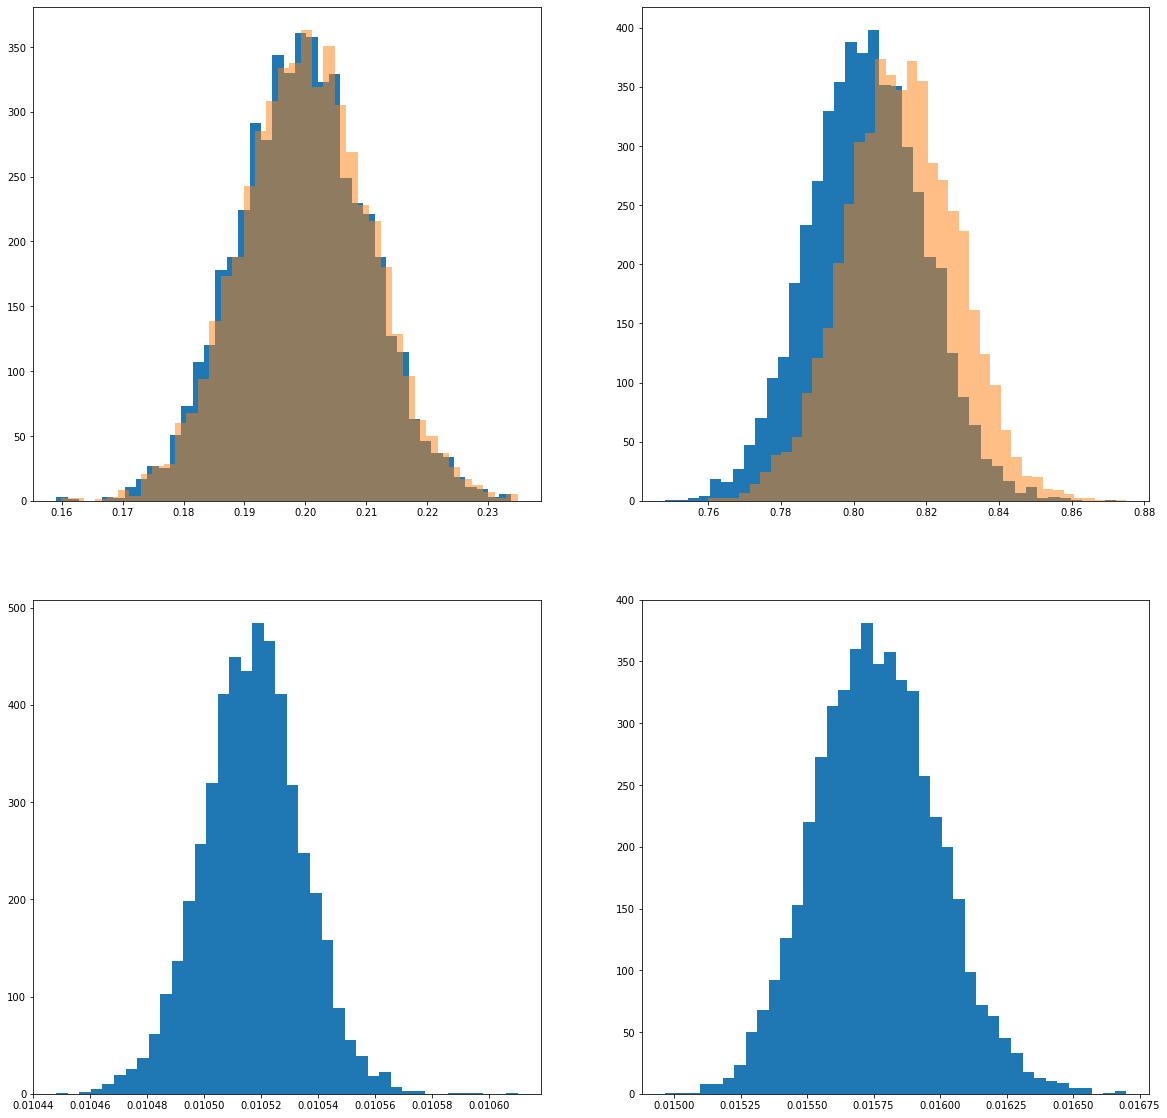

In [57]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].hist( chi2_fit_mu_val, bins=40 )
ax[0][0].hist( chi2_fit_diag_mu_val, bins=40, alpha=0.5 )

ax[0][1].hist( chi2_fit_sig2_val, bins=40 )
ax[0][1].hist( chi2_fit_diag_sig2_val, bins=40, alpha=0.5 )


ax[1][0].hist( chi2_fit_mu_err, bins=40 )

ax[1][1].hist( chi2_fit_sig2_err, bins=40 )


plt.show

In [58]:



mean_mu = np.mean( chi2_fit_mu_val )
mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

mean_sig2 = np.mean( chi2_fit_sig2_val )
mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

mean_mu_fit_err = np.mean( chi2_fit_mu_err )
mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )





mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )




print('\n\n')
print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
print('\n\n')






 mean:  0.1995, rms  0.0105, mean fit err  0.0105  |  diag. chi2 fit    0.2001, rms  0.0105, mean fit err  0.0059
 sig2:  0.8037, rms  0.0156, mean fit err  0.0158  |  diag. chi2 fit    0.8131, rms  0.0154, mean fit err  0.0080



